# モデル選定に関する収益ノートブック

## パラメータで選択したモデルたちがどんなものなのか実際に確認する

In [78]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot as plt

import seaborn
from pandas import DataFrame
from tqdm import tqdm
from imblearn.under_sampling import RandomUnderSampler #アンダーサンプリング用
from sklearn.model_selection import train_test_split
import pickle
# 機械学習用
from sklearn.cluster import KMeans #クラスタリング用
from sklearn.ensemble import RandomForestClassifier#ランダムフォレスト
from copy import deepcopy as cp
from sklearn.linear_model import LogisticRegression
import time
import datetime
from dateutil.relativedelta import relativedelta
import os #ディレクトリ作成用
import xgboost as xgb
import sys
from sklearn.preprocessing import StandardScaler#モデルの評価用に標準化する関数
import scipy.stats#モデルの評価用に標準化する関数
import warnings

#自作のモジュールのインポート
sys.path.append("..")
import module.master as master
import module.modeling_scores as modeling


# 関数

In [2]:
def add_std_score(good_model_df,feature_weights):#偏差値と相関係数をもとにしたスコアを与える
    add_score_df=pd.DataFrame()
    for com in sorted(good_model_df['target_com'].value_counts().index):
        target_com_df=good_model_df[good_model_df['target_com']==com]
        for f_name,weight in feature_weights.items():
            target_com_df.loc[:,'{}_score'.format(f_name)]=scipy.stats.zscore(target_com_df['{}'.format(f_name)].values)
            target_com_df.loc[:,'{}_score'.format(f_name)]=target_com_df['{}_score'.format(f_name)]*weight
        target_com_df=target_com_df.fillna(0)
        target_com_df['score']=0
        for f_name in feature_weights.index:
            target_com_df['score']=target_com_df['score']+target_com_df['{}_score'.format(f_name)]
        #display(target_com_df)
        add_score_df=pd.concat([add_score_df, target_com_df], axis=0)#きめのパラメータで切り落としたので結合
    
    return add_score_df


def select_use_model(model_std_score_df):#相関係数と標準偏差によって与えられたscoreをもとに最終的に使用するモデルを選定する関数
    use_model_df=pd.DataFrame()
    for com in sorted(model_std_score_df['target_com'].value_counts().index):
        target_com_df=model_std_score_df[model_std_score_df['target_com']==com].copy()
        com_selected_row=target_com_df.sort_values('score', ascending=False).iloc[:1]
        #use_model_df=pd.concat([use_model_df, com_selected_row], axis=0)#きめのパラメータで切り落としたので結合
        use_model_df=use_model_df.append(com_selected_row,ignore_index=True)
    return use_model_df


def twin_plt(x,y1,y2,x_n,y1_n,y2_n):#2本軸でのグラフの描写
    fig = plt.figure(figsize=(19,8))
    plt.tick_params(colors='black')
    plt.rcParams["font.size"] = 18
    
    ax1 = fig.add_subplot()
    fig.set_facecolor(color='white')
    ax1.plot(x, y1,label=y1_n)
    ax1.tick_params()
    plt.ylim(80, 200)
    ax2 = ax1.twinx()
    #print(y2)
    ax2.plot(x, y2,label=y2_n,color='red')
    ax1.axhline(100,ls = "-.",color='green')
    #ax2.tick_params(colors='white')
    ax2.tick_params()

    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1+h2, l1+l2, loc='lower center')

    #ax1.set_xlabel(x_n,color='white')
    #ax1.set_ylabel(y1_n,color='white')
    #ax2.set_ylabel(y2_n,color='white')
    ax1.set_xlabel(x_n)
    ax1.set_ylabel(y1_n)
    ax2.set_ylabel(y2_n)
    plt.show()
    return None

## きめのパラメータでモデルを大ざっぱに切り落としたのちに，相関係数とスケーリングした標準偏差をもとに最終的に使用するモデルを決定する(芦屋のみ)

In [71]:
# 芦屋だけでひとまず機能を完成させる
#きめのパラメータ
place_name='asiya'
plus_m_th=3
num_hit_th=5
version='V4_2'
mode='asiya_model_score_'
mode_type='recent'
csv_path='../../bot_database/{place_name}/model_score_{place_name}/v4_score/{version}/{version}_{mode_type}_TRhit_pM{plus_month}_total_analysis.csv'.format(place_name=place_name,mode_type=mode_type,version=version,plus_month=plus_m_th,num_hit=num_hit_th)
totol_analysis_df=pd.read_csv(csv_path, encoding='utf_8_sig')
totol_analysis_df=totol_analysis_df.drop(["Unnamed: 0"],axis=1)

#閾値の取得
th_s=totol_analysis_df[totol_analysis_df['num_plus_com_mean']>2].sort_values('minus_model_per_mean').iloc[0]#plusだったcom数の平均が２より大きい
#th_s=totol_analysis_df[totol_analysis_df['num_plus_com_mean']>3].sort_values('minus_model_per_mean').iloc[0]

dates=[datetime.datetime(year=2020, month=1+(i*3),day=1).strftime('%Y%m%d') for i in range(4)]#今回のテストで使用する日付たち

#th_s=totol_analysis_df[(totol_analysis_df['num_plus_com_mean']>3) & (totol_analysis_df['num_hit_th']>=10)].sort_values('minus_model_per_mean').iloc[0]
select_model_df=pd.DataFrame()
#閾値にあてはまった　モデルたちがどんな奴らなのかを確認する
for i in range(4):
    now_ym=datetime.datetime(year=2020, month=1+(i*3),day=1).strftime('%Y%m%d')
    dir_path='../../bot_database/{place_name}/model_score_{place_name}/v4_score/{version}/{mode}st{now_ym}_finalM3_{version}.csv'.format(place_name=place_name,mode=mode,now_ym=now_ym,version=version)
    model_score_df=pd.read_csv(dir_path, encoding='utf_8_sig')
    model_score_df=model_score_df.drop(["Unnamed: 0"],axis=1)
    #選定したパラメータで切り落とし

    
    selected_m=model_score_df[model_score_df['gain_test']>=th_s["gain_th"]].copy()
    selected_m=selected_m[selected_m['gain_std_test']<=th_s["gain_std_th"]].copy()
    selected_m=selected_m[selected_m['buy_hit_per_test']>=th_s["hit_per_th"]].copy()
    selected_m=selected_m[selected_m['buy_hit_per_std_test']<=th_s["hit_std_th"]].copy()
    selected_m=selected_m[selected_m['num_hit_test']>=th_s["num_hit_th"]].copy()#的中した予測の数で切り捨てる,これも可変していく方針に変更した
    print(now_ym,'=============================================')
    #display(selected_m)
    select_model_df=pd.concat([select_model_df, selected_m], axis=0)#きめのパラメータで切り落としたので結合
    #偏差値評価を用いた実際に使用するモデルの切り抜き(方針：使用する区間の１つ前の区間(test5,final3の区間))をもとに相関係数を算出
    use_date=dates[i-1]#一つ前の区間の日付を切り抜く
    dir_path='../../bot_database/{place_name}/model_score_{place_name}/v4_score/{version}/{mode}st{now_ym}_finalM3_{version}.csv'.format(place_name=place_name,mode=mode,now_ym=use_date,version=version)
    print(dir_path)
    model_score_df=pd.read_csv(dir_path, encoding='utf_8_sig')
    model_score_df=model_score_df.drop(["Unnamed: 0"],axis=1)
     #決めのパラメータでいったん切り落とし
    model_score_df=model_score_df[model_score_df['plus_month_num_test']>=plus_m_th].copy()#収益がプラスだった月の数で切り捨てる
    model_score_df=model_score_df[model_score_df['num_hit_test']>=num_hit_th].copy()#的中した予測の数で切り捨てる，大体一カ月に一件くらいをイメージ
    version_corr_df=model_score_df.corr()
    feature_weights=version_corr_df.loc['gain_final']['total_get_test':'diff_mea_med_test']#相関係数を代用した変数ごとの重みづけ
    print('now_date:',now_ym)
    print('corr_date:',use_date)
    
    print(feature_weights)
    model_score_df=add_std_score(select_model_df,feature_weights)
    
    
    use_models=select_use_model(model_score_df)#相関係数と標準偏差によって与えられたscoreをもとに最終的に使用するモデルを選定する関数
    use_models.to_csv('csv/use_model_df_{}.csv'.format(now_ym))
    dir_path = "../../bot_database/{place_name}/model_score_{place_name}/use_model/{version}/use_model_{place_name}_{now_ym}_{version}.csv".format(place_name=place_name,version=version,now_ym=now_ym)#作成したデータの書き込み先#使用するデータの読み込み
    use_models.to_csv(dir_path.format(now_ym))

20200101 =============================================
../../bot_database/asiya/model_score_asiya/v4_score/V4_2/asiya_model_score_st20201001_finalM3_V4_2.csv
now_date: 20200101
corr_date: 20201001
total_get_test         -0.090709
total_use_test          0.062187
num_com_test           -0.349830
num_pred_test           0.062187
gain_test              -0.270487
gain_std_test           0.163454
num_hit_test           -0.248627
buy_hit_per_test       -0.231839
buy_hit_per_std_test   -0.204338
plus_month_num_test    -0.201576
diff_mea_med_test       0.297899
Name: gain_final, dtype: float64
20200401 =============================================
../../bot_database/asiya/model_score_asiya/v4_score/V4_2/asiya_model_score_st20200101_finalM3_V4_2.csv
now_date: 20200401
corr_date: 20200101
total_get_test         -0.277565
total_use_test         -0.438106
num_com_test           -0.400590
num_pred_test          -0.438106
gain_test               0.148706
gain_std_test           0.334047
num_hit_test

c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

20200701 =============================================
../../bot_database/asiya/model_score_asiya/v4_score/V4_2/asiya_model_score_st20200401_finalM3_V4_2.csv
now_date: 20200701
corr_date: 20200401
total_get_test         -0.410224
total_use_test         -0.451530
num_com_test           -0.163571
num_pred_test          -0.451530
gain_test               0.132342
gain_std_test          -0.028430
num_hit_test           -0.184070
buy_hit_per_test        0.499386
buy_hit_per_std_test   -0.102880
plus_month_num_test    -0.186400
diff_mea_med_test      -0.110651
Name: gain_final, dtype: float64
20201001 =============================================
../../bot_database/asiya/model_score_asiya/v4_score/V4_2/asiya_model_score_st20200701_finalM3_V4_2.csv
now_date: 20201001
corr_date: 20200701
total_get_test         -0.491165
total_use_test         -0.361793
num_com_test            0.061008
num_pred_test          -0.361793
gain_test              -0.085998
gain_std_test          -0.247103
num_hit_test

c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

## 各シーズンごとの収益とcom数の推移(選定された全モデル)

<ipython-input-2-6df26f47718d>:33: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


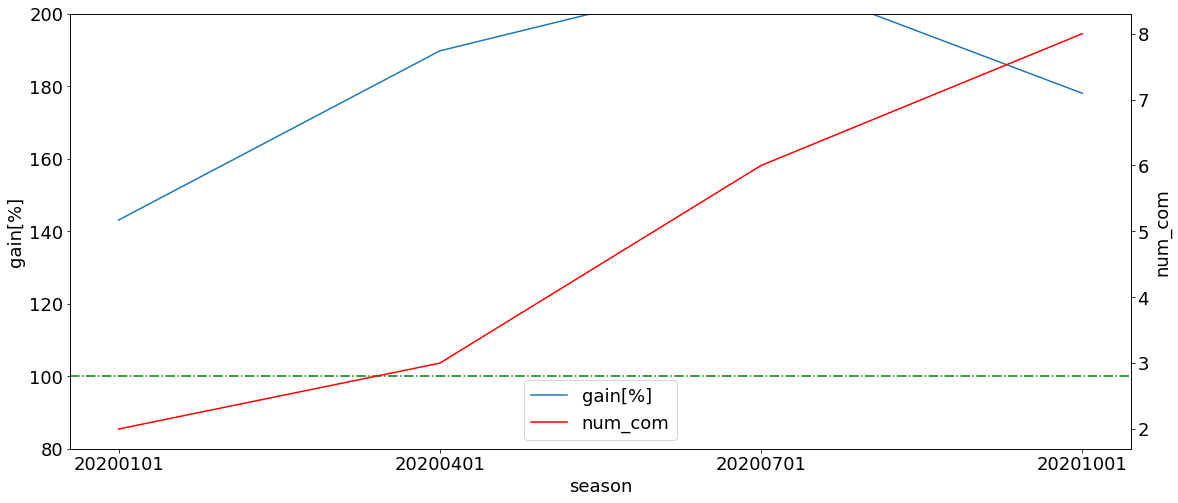

In [72]:
gain_arr=[0]*4
n_com_arr=[0]*4
date_arr=[0]*4
for i in range(4):
    now_ym=datetime.datetime(year=2020, month=1+(i*3),day=1).strftime('%Y%m%d')
    dir_path='csv/use_model_df_{}.csv'.format(now_ym)
    use_models=pd.read_csv(dir_path, encoding='utf_8_sig')
    #display(use_models)
    s_t_use=use_models['total_use_final'].sum()
    s_t_get=use_models['total_get_final'].sum()
    s_gain=(s_t_get/s_t_use)*100
    gain_arr[i]=s_gain
    n_com_arr[i]=len(use_models)
    date_arr[i]=now_ym
x_n='season'
y1_n='gain[%]'
y2_n='num_com'
twin_plt(date_arr,gain_arr,n_com_arr,x_n,y1_n,y2_n)

In [73]:
th_s

minus_model_per_mean                22.247024
num_plus_com_mean                    2.250000
num_plus_model_mean                 39.000000
gain_th                            140.000000
gain_std_th                        160.000000
hit_per_th                           4.000000
hit_std_th                           0.800000
num_hit_th                           3.000000
st_20200101_minus_per(model)         0.000000
st_20200101_num_plus_com             2.000000
st_20200101_num_plus_model(row)      2.000000
st_20200401_minus_per(model)         0.000000
st_20200401_num_plus_com             1.000000
st_20200401_num_plus_model(row)     11.000000
st_20200701_minus_per(model)         0.000000
st_20200701_num_plus_com             3.000000
st_20200701_num_plus_model(row)    106.000000
st_20201001_minus_per(model)        88.988095
st_20201001_num_plus_com             3.000000
st_20201001_num_plus_model(row)     37.000000
Name: 100019, dtype: float64

# 多会場版（いったんモデリングが済んでいる１０会場で．）

In [3]:
version='V4_2'#バージョン
#use_modelの書き込み先作成のための箱作り
place_master=master.get_place_master()
for place in place_master.items():
    #print(place[0],place[1],'\n')
    place_name=place[1]
    dir_path = "../../bot_database/{place_name}/model_score_{place_name}/use_model/{version}".format(place_name=place_name,version=version)#作成したデータの書き込み先#使用するデータの読み込み
    if os.path.exists(dir_path)==False:
        os.makedirs(dir_path)
    else:
        pass

In [82]:
warnings.simplefilter('ignore')
#相関係数と全体分析の結果をもとに最終的に使用するモデルを選定する
place_master=master.get_place_master()
place_names=[place_name for place_name in place_master.values()]#会場名のみを収納した配列
#絶対に固定のパラメータたち
plus_m_th=2
#plus_m_th=3
num_hit_th=5
version='V4_2'
mode='model_score_'
mode_type='recent'
#コード本文
for place_name in place_names[:10]:
    csv_path='../../bot_database/{place_name}/model_score_{place_name}/v4_score/{version}/{version}_{mode_type}_TRhit_pM{plus_month}_total_analysis.csv'.format(place_name=place_name,mode_type=mode_type,version=version,plus_month=plus_m_th,num_hit=num_hit_th)
    totol_analysis_df=pd.read_csv(csv_path, encoding='utf_8_sig')
    totol_analysis_df=totol_analysis_df.drop(["Unnamed: 0"],axis=1)
    print('place_name:',place_name,'========================================================================================')
    #閾値の取得
    th_s=totol_analysis_df[totol_analysis_df['num_plus_com_mean']>2].sort_values('minus_model_per_mean').iloc[0]#plusだったcom数の平均が２より大きい
    #th_s=totol_analysis_df[totol_analysis_df['num_plus_com_mean']>3].sort_values('minus_model_per_mean').iloc[0]#plusだったcom数の平均が２より大きい
    display(th_s)
    dates=[datetime.datetime(year=2020, month=1+(i*3),day=1).strftime('%Y%m%d') for i in range(4)]#今回のテストで使用する日付たち
    select_model_df=pd.DataFrame()
    
    #閾値にあてはまった　モデルたちがどんな奴らなのかを確認する
    for i in range(4):
        now_ym=datetime.datetime(year=2020, month=1+(i*3),day=1).strftime('%Y%m%d')
        print('now_date:',now_ym)
        dir_path='../../bot_database/{place_name}/model_score_{place_name}/v4_score/{version}/{place_name}_{mode}st{now_ym}_finalM3_{version}.csv'.format(place_name=place_name,mode=mode,now_ym=now_ym,version=version)
        model_score_df=pd.read_csv(dir_path, encoding='utf_8_sig')
        model_score_df=model_score_df.drop(["Unnamed: 0"],axis=1)
        #選定したパラメータで切り落とし
        selected_m=model_score_df[model_score_df['gain_test']>=th_s["gain_th"]].copy()
        selected_m=selected_m[selected_m['gain_std_test']<=th_s["gain_std_th"]].copy()
        selected_m=selected_m[selected_m['buy_hit_per_test']>=th_s["hit_per_th"]].copy()
        selected_m=selected_m[selected_m['buy_hit_per_std_test']<=th_s["hit_std_th"]].copy()
        selected_m=selected_m[selected_m['num_hit_test']>=th_s["num_hit_th"]].copy()#的中した予測の数で切り捨てる,これも可変していく方針に変更した
        select_model_df=pd.concat([select_model_df, selected_m], axis=0)#きめのパラメータで切り落としたので結合
        
        
#         #偏差値評価を用いた実際に使用するモデルの切り抜き(方針：使用する区間の１つ前の区間(test5,final3の区間))をもとに相関係数を算出
        use_date=dates[i-1]#一つ前の区間の日付を切り抜く
        dir_path='../../bot_database/{place_name}/model_score_{place_name}/v4_score/{version}/{place_name}_{mode}st{now_ym}_finalM3_{version}.csv'.format(place_name=place_name,mode=mode,now_ym=use_date,version=version)
        #print(dir_path)
        model_score_df=pd.read_csv(dir_path, encoding='utf_8_sig')
        model_score_df=model_score_df.drop(["Unnamed: 0"],axis=1)
        #決めのパラメータでいったん切り落とし
        model_score_df=model_score_df[model_score_df['plus_month_num_test']>=plus_m_th].copy()#収益がプラスだった月の数で切り捨てる
        model_score_df=model_score_df[model_score_df['num_hit_test']>=num_hit_th].copy()#的中した予測の数で切り捨てる，大体一カ月に一件くらいをイメージ
        version_corr_df=model_score_df.corr()
        feature_weights=version_corr_df.loc['gain_final']['total_get_test':'diff_mea_med_test']#相関係数を代用した変数ごとの重みづけ
        print(feature_weights)
        #display(feature_weights)
        model_std_score_df=add_std_score(select_model_df,feature_weights)
        if place_name=='toda':
            model_std_score_df.to_csv('csv/toda_{dt}.csv'.format(dt=now_ym))
        use_models=select_use_model(model_std_score_df)#相関係数と標準偏差によって与えられたscoreをもとに最終的に使用するモデルを選定する関数
        dir_path = "../../bot_database/{place_name}/model_score_{place_name}/use_model/{version}/use_model_{place_name}_{now_ym}_{version}.csv".format(place_name=place_name,version=version,now_ym=now_ym)#作成したデータの書き込み先#使用するデータの読み込み
        use_models.to_csv(dir_path)

place_name: kiryu ========================================================================================


minus_model_per_mean                62.135142
num_plus_com_mean                    4.750000
num_plus_model_mean                122.250000
gain_th                            100.000000
gain_std_th                        130.000000
hit_per_th                           0.000000
hit_std_th                           0.400000
num_hit_th                           3.000000
st_20200101_minus_per(model)        47.596154
st_20200101_num_plus_com            10.000000
st_20200101_num_plus_model(row)    218.000000
st_20200401_minus_per(model)        66.855524
st_20200401_num_plus_com             2.000000
st_20200401_num_plus_model(row)    117.000000
st_20200701_minus_per(model)        77.200000
st_20200701_num_plus_com             5.000000
st_20200701_num_plus_model(row)     57.000000
st_20201001_minus_per(model)        56.888889
st_20201001_num_plus_com             2.000000
st_20201001_num_plus_model(row)     97.000000
Name: 4401, dtype: float64

now_date: 20200101
total_get_test          0.368025
total_use_test         -0.124537
num_com_test           -0.624872
num_pred_test          -0.124537
gain_test               0.418493
gain_std_test           0.447960
num_hit_test           -0.385362
buy_hit_per_test       -0.294876
buy_hit_per_std_test    0.055077
plus_month_num_test    -0.120445
diff_mea_med_test       0.051350
Name: gain_final, dtype: float64
now_date: 20200401
total_get_test         -0.183240
total_use_test         -0.306624
num_com_test           -0.079752
num_pred_test          -0.306624
gain_test               0.184908
gain_std_test           0.539687
num_hit_test           -0.114220
buy_hit_per_test        0.089459
buy_hit_per_std_test    0.130295
plus_month_num_test    -0.137310
diff_mea_med_test      -0.064851
Name: gain_final, dtype: float64
now_date: 20200701
total_get_test         -0.096598
total_use_test         -0.163600
num_com_test            0.231963
num_pred_test          -0.163600
gain_test          

minus_model_per_mean               16.954685
num_plus_com_mean                   2.250000
num_plus_model_mean                20.750000
gain_th                            96.000000
gain_std_th                        85.000000
hit_per_th                          6.000000
hit_std_th                          1.600000
num_hit_th                          5.000000
st_20200101_minus_per(model)        9.523810
st_20200101_num_plus_com            3.000000
st_20200101_num_plus_model(row)    38.000000
st_20200401_minus_per(model)       35.714286
st_20200401_num_plus_com            2.000000
st_20200401_num_plus_model(row)     9.000000
st_20200701_minus_per(model)       22.580645
st_20200701_num_plus_com            2.000000
st_20200701_num_plus_model(row)    24.000000
st_20201001_minus_per(model)        0.000000
st_20201001_num_plus_com            2.000000
st_20201001_num_plus_model(row)    12.000000
Name: 23469, dtype: float64

now_date: 20200101
total_get_test          0.401807
total_use_test         -0.050850
num_com_test            0.367733
num_pred_test          -0.050850
gain_test               0.574735
gain_std_test           0.463093
num_hit_test            0.412548
buy_hit_per_test        0.393066
buy_hit_per_std_test    0.309202
plus_month_num_test     0.064271
diff_mea_med_test      -0.123069
Name: gain_final, dtype: float64
now_date: 20200401
total_get_test          0.061033
total_use_test          0.013634
num_com_test            0.252722
num_pred_test           0.013634
gain_test               0.059339
gain_std_test           0.398192
num_hit_test            0.017281
buy_hit_per_test        0.012094
buy_hit_per_std_test    0.431983
plus_month_num_test    -0.341734
diff_mea_med_test       0.150974
Name: gain_final, dtype: float64
now_date: 20200701
total_get_test         -0.160664
total_use_test         -0.126350
num_com_test           -0.318119
num_pred_test          -0.126350
gain_test          

minus_model_per_mean                30.134409
num_plus_com_mean                    2.250000
num_plus_model_mean                 12.250000
gain_th                            160.000000
gain_std_th                        190.000000
hit_per_th                           4.000000
hit_std_th                           1.200000
num_hit_th                           5.000000
st_20200101_minus_per(model)        36.666667
st_20200101_num_plus_com             3.000000
st_20200101_num_plus_model(row)     19.000000
st_20200401_minus_per(model)        83.870968
st_20200401_num_plus_com             4.000000
st_20200401_num_plus_model(row)     25.000000
st_20200701_minus_per(model)         0.000000
st_20200701_num_plus_com             1.000000
st_20200701_num_plus_model(row)      1.000000
st_20201001_minus_per(model)         0.000000
st_20201001_num_plus_com             1.000000
st_20201001_num_plus_model(row)      4.000000
Name: 36613, dtype: float64

now_date: 20200101
total_get_test         -0.500665
total_use_test         -0.412065
num_com_test            0.114903
num_pred_test          -0.412065
gain_test              -0.003466
gain_std_test          -0.117646
num_hit_test            0.013074
buy_hit_per_test        0.354493
buy_hit_per_std_test    0.231138
plus_month_num_test     0.148255
diff_mea_med_test      -0.047029
Name: gain_final, dtype: float64
now_date: 20200401
total_get_test          0.039488
total_use_test         -0.064439
num_com_test            0.071213
num_pred_test          -0.064439
gain_test               0.068928
gain_std_test           0.202996
num_hit_test           -0.054804
buy_hit_per_test       -0.042214
buy_hit_per_std_test   -0.084304
plus_month_num_test    -0.111242
diff_mea_med_test       0.011801
Name: gain_final, dtype: float64
now_date: 20200701
total_get_test          0.264987
total_use_test          0.039464
num_com_test           -0.342509
num_pred_test           0.039464
gain_test          

minus_model_per_mean                49.935985
num_plus_com_mean                    2.500000
num_plus_model_mean                 23.000000
gain_th                            160.000000
gain_std_th                        190.000000
hit_per_th                           2.000000
hit_std_th                           0.800000
num_hit_th                           8.000000
st_20200101_minus_per(model)        85.416667
st_20200101_num_plus_com             2.000000
st_20200101_num_plus_model(row)      7.000000
st_20200401_minus_per(model)         0.000000
st_20200401_num_plus_com             2.000000
st_20200401_num_plus_model(row)      9.000000
st_20200701_minus_per(model)        72.727273
st_20200701_num_plus_com             2.000000
st_20200701_num_plus_model(row)      3.000000
st_20201001_minus_per(model)        41.600000
st_20201001_num_plus_com             4.000000
st_20201001_num_plus_model(row)     73.000000
Name: 56607, dtype: float64

now_date: 20200101
total_get_test         -0.131295
total_use_test         -0.034600
num_com_test           -0.190108
num_pred_test          -0.034600
gain_test              -0.122373
gain_std_test          -0.089498
num_hit_test           -0.170536
buy_hit_per_test       -0.247495
buy_hit_per_std_test    0.039285
plus_month_num_test     0.110036
diff_mea_med_test      -0.328958
Name: gain_final, dtype: float64
now_date: 20200401
total_get_test         -0.415810
total_use_test         -0.203399
num_com_test            0.053784
num_pred_test          -0.203399
gain_test              -0.309611
gain_std_test          -0.021112
num_hit_test           -0.006235
buy_hit_per_test        0.096557
buy_hit_per_std_test    0.239229
plus_month_num_test    -0.089371
diff_mea_med_test      -0.243153
Name: gain_final, dtype: float64
now_date: 20200701
total_get_test          0.074861
total_use_test          0.014911
num_com_test            0.068123
num_pred_test           0.014911
gain_test          

minus_model_per_mean                35.136901
num_plus_com_mean                    2.500000
num_plus_model_mean                 52.250000
gain_th                            108.000000
gain_std_th                        115.000000
hit_per_th                           6.000000
hit_std_th                           1.200000
num_hit_th                           8.000000
st_20200101_minus_per(model)         0.000000
st_20200101_num_plus_com             3.000000
st_20200101_num_plus_model(row)    109.000000
st_20200401_minus_per(model)        92.721519
st_20200401_num_plus_com             2.000000
st_20200401_num_plus_model(row)     23.000000
st_20200701_minus_per(model)        47.826087
st_20200701_num_plus_com             4.000000
st_20200701_num_plus_model(row)     72.000000
st_20201001_minus_per(model)         0.000000
st_20201001_num_plus_com             1.000000
st_20201001_num_plus_model(row)      5.000000
Name: 45968, dtype: float64

now_date: 20200101
total_get_test         -0.110042
total_use_test         -0.155079
num_com_test            0.070552
num_pred_test          -0.155079
gain_test              -0.019023
gain_std_test          -0.245250
num_hit_test            0.021304
buy_hit_per_test        0.180267
buy_hit_per_std_test    0.134610
plus_month_num_test     0.141312
diff_mea_med_test       0.138363
Name: gain_final, dtype: float64
now_date: 20200401
total_get_test          0.102356
total_use_test         -0.157327
num_com_test            0.029481
num_pred_test          -0.157327
gain_test               0.307864
gain_std_test           0.261075
num_hit_test            0.002535
buy_hit_per_test        0.170586
buy_hit_per_std_test    0.042212
plus_month_num_test     0.219195
diff_mea_med_test      -0.021454
Name: gain_final, dtype: float64
now_date: 20200701
total_get_test         -0.096323
total_use_test          0.031015
num_com_test            0.251075
num_pred_test           0.031015
gain_test          

minus_model_per_mean                51.939811
num_plus_com_mean                    2.250000
num_plus_model_mean                 24.750000
gain_th                            124.000000
gain_std_th                        235.000000
hit_per_th                           2.000000
hit_std_th                           0.800000
num_hit_th                           8.000000
st_20200101_minus_per(model)        28.571429
st_20200101_num_plus_com             4.000000
st_20200101_num_plus_model(row)     55.000000
st_20200401_minus_per(model)       100.000000
st_20200401_num_plus_com             0.000000
st_20200401_num_plus_model(row)      0.000000
st_20200701_minus_per(model)         0.000000
st_20200701_num_plus_com             1.000000
st_20200701_num_plus_model(row)      3.000000
st_20201001_minus_per(model)        79.187817
st_20201001_num_plus_com             4.000000
st_20201001_num_plus_model(row)     41.000000
Name: 49557, dtype: float64

now_date: 20200101
total_get_test          0.143638
total_use_test          0.043183
num_com_test           -0.077725
num_pred_test           0.043183
gain_test               0.108522
gain_std_test           0.142740
num_hit_test            0.027660
buy_hit_per_test        0.004478
buy_hit_per_std_test   -0.242829
plus_month_num_test    -0.253062
diff_mea_med_test       0.132120
Name: gain_final, dtype: float64
now_date: 20200401
total_get_test          0.066046
total_use_test          0.222537
num_com_test            0.495555
num_pred_test           0.222537
gain_test              -0.082567
gain_std_test          -0.130789
num_hit_test            0.445356
buy_hit_per_test        0.240348
buy_hit_per_std_test    0.017235
plus_month_num_test     0.187776
diff_mea_med_test       0.190083
Name: gain_final, dtype: float64
now_date: 20200701
total_get_test         -0.189996
total_use_test          0.032515
num_com_test            0.255817
num_pred_test           0.032515
gain_test          

minus_model_per_mean                33.069829
num_plus_com_mean                    2.250000
num_plus_model_mean                 48.000000
gain_th                            108.000000
gain_std_th                        130.000000
hit_per_th                           6.000000
hit_std_th                           1.200000
num_hit_th                           5.000000
st_20200101_minus_per(model)        23.188406
st_20200101_num_plus_com             4.000000
st_20200101_num_plus_model(row)    159.000000
st_20200401_minus_per(model)         9.090909
st_20200401_num_plus_com             4.000000
st_20200401_num_plus_model(row)     30.000000
st_20200701_minus_per(model)       100.000000
st_20200701_num_plus_com             0.000000
st_20200701_num_plus_model(row)      0.000000
st_20201001_minus_per(model)         0.000000
st_20201001_num_plus_com             1.000000
st_20201001_num_plus_model(row)      3.000000
Name: 26018, dtype: float64

now_date: 20200101
total_get_test         -0.191570
total_use_test         -0.091989
num_com_test            0.382495
num_pred_test          -0.091989
gain_test              -0.150283
gain_std_test          -0.154787
num_hit_test            0.053120
buy_hit_per_test        0.187409
buy_hit_per_std_test    0.098853
plus_month_num_test    -0.164583
diff_mea_med_test       0.084350
Name: gain_final, dtype: float64
now_date: 20200401
total_get_test         -0.313227
total_use_test         -0.250924
num_com_test            0.344404
num_pred_test          -0.250924
gain_test              -0.038465
gain_std_test          -0.318862
num_hit_test            0.214450
buy_hit_per_test        0.496081
buy_hit_per_std_test    0.465607
plus_month_num_test     0.257884
diff_mea_med_test      -0.311481
Name: gain_final, dtype: float64
now_date: 20200701
total_get_test          0.272429
total_use_test         -0.024965
num_com_test           -0.141486
num_pred_test          -0.024965
gain_test          

minus_model_per_mean                39.015152
num_plus_com_mean                    2.250000
num_plus_model_mean                 22.000000
gain_th                            144.000000
gain_std_th                        160.000000
hit_per_th                           4.000000
hit_std_th                           1.600000
num_hit_th                           3.000000
st_20200101_minus_per(model)        39.393939
st_20200101_num_plus_com             5.000000
st_20200101_num_plus_model(row)     80.000000
st_20200401_minus_per(model)       100.000000
st_20200401_num_plus_com             0.000000
st_20200401_num_plus_model(row)      0.000000
st_20200701_minus_per(model)        16.666667
st_20200701_num_plus_com             2.000000
st_20200701_num_plus_model(row)      5.000000
st_20201001_minus_per(model)         0.000000
st_20201001_num_plus_com             2.000000
st_20201001_num_plus_model(row)      3.000000
Name: 13314, dtype: float64

now_date: 20200101
total_get_test         -0.119173
total_use_test         -0.129874
num_com_test           -0.220686
num_pred_test          -0.129874
gain_test              -0.014739
gain_std_test           0.009578
num_hit_test           -0.141709
buy_hit_per_test       -0.101000
buy_hit_per_std_test   -0.031072
plus_month_num_test    -0.043227
diff_mea_med_test      -0.063667
Name: gain_final, dtype: float64
now_date: 20200401
total_get_test         -0.173832
total_use_test         -0.097496
num_com_test           -0.121616
num_pred_test          -0.097496
gain_test              -0.019037
gain_std_test          -0.216762
num_hit_test            0.008429
buy_hit_per_test        0.158264
buy_hit_per_std_test    0.029148
plus_month_num_test     0.019837
diff_mea_med_test      -0.135740
Name: gain_final, dtype: float64
now_date: 20200701
total_get_test         -0.061227
total_use_test         -0.049506
num_com_test           -0.189779
num_pred_test          -0.049506
gain_test          

minus_model_per_mean                26.960784
num_plus_com_mean                    2.250000
num_plus_model_mean                  7.000000
gain_th                            148.000000
gain_std_th                        175.000000
hit_per_th                           4.000000
hit_std_th                           1.600000
num_hit_th                           8.000000
st_20200101_minus_per(model)         0.000000
st_20200101_num_plus_com             1.000000
st_20200101_num_plus_model(row)      8.000000
st_20200401_minus_per(model)        41.666667
st_20200401_num_plus_com             3.000000
st_20200401_num_plus_model(row)      7.000000
st_20200701_minus_per(model)        41.176471
st_20200701_num_plus_com             3.000000
st_20200701_num_plus_model(row)     10.000000
st_20201001_minus_per(model)        25.000000
st_20201001_num_plus_com             2.000000
st_20201001_num_plus_model(row)      3.000000
Name: 54164, dtype: float64

now_date: 20200101
total_get_test          0.164491
total_use_test          0.454386
num_com_test            0.385786
num_pred_test           0.454386
gain_test              -0.353817
gain_std_test          -0.386185
num_hit_test            0.411896
buy_hit_per_test        0.186153
buy_hit_per_std_test   -0.374995
plus_month_num_test    -0.123105
diff_mea_med_test       0.255600
Name: gain_final, dtype: float64
now_date: 20200401
total_get_test          0.349733
total_use_test          0.129576
num_com_test            0.221259
num_pred_test           0.129576
gain_test               0.483258
gain_std_test           0.179924
num_hit_test            0.211485
buy_hit_per_test        0.230467
buy_hit_per_std_test   -0.005949
plus_month_num_test    -0.048650
diff_mea_med_test      -0.231214
Name: gain_final, dtype: float64
now_date: 20200701
total_get_test          0.089696
total_use_test          0.107724
num_com_test           -0.092505
num_pred_test           0.107724
gain_test          

minus_model_per_mean               40.159193
num_plus_com_mean                   2.250000
num_plus_model_mean                20.000000
gain_th                            96.000000
gain_std_th                        70.000000
hit_per_th                          2.000000
hit_std_th                          0.800000
num_hit_th                         10.000000
st_20200101_minus_per(model)       53.571429
st_20200101_num_plus_com            1.000000
st_20200101_num_plus_model(row)    13.000000
st_20200401_minus_per(model)        0.000000
st_20200401_num_plus_com            1.000000
st_20200401_num_plus_model(row)     2.000000
st_20200701_minus_per(model)       90.163934
st_20200701_num_plus_com            3.000000
st_20200701_num_plus_model(row)     6.000000
st_20201001_minus_per(model)       16.901408
st_20201001_num_plus_com            4.000000
st_20201001_num_plus_model(row)    59.000000
Name: 63407, dtype: float64

now_date: 20200101
total_get_test         -0.268162
total_use_test          0.068062
num_com_test            0.536347
num_pred_test           0.068062
gain_test              -0.360848
gain_std_test          -0.337633
num_hit_test            0.308776
buy_hit_per_test        0.263679
buy_hit_per_std_test    0.256875
plus_month_num_test    -0.180861
diff_mea_med_test       0.043707
Name: gain_final, dtype: float64
now_date: 20200401
total_get_test         -0.071986
total_use_test         -0.200528
num_com_test            0.339127
num_pred_test          -0.200528
gain_test               0.135774
gain_std_test          -0.045499
num_hit_test            0.277153
buy_hit_per_test        0.565625
buy_hit_per_std_test    0.598274
plus_month_num_test     0.106082
diff_mea_med_test       0.160768
Name: gain_final, dtype: float64
now_date: 20200701
total_get_test          0.056048
total_use_test          0.128753
num_com_test           -0.119493
num_pred_test           0.128753
gain_test          

# 多会場版でも同様にuse_modelたちの一年間の利益推移を確認する

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

place_name: kiryu ========================================================================================
../../bot_database/kiryu/model_score_kiryu/use_model/V4_2/use_model_kiryu_20200101_V4_2.csv
../../bot_database/kiryu/model_score_kiryu/use_model/V4_2/use_model_kiryu_20200401_V4_2.csv
../../bot_database/kiryu/model_score_kiryu/use_model/V4_2/use_model_kiryu_20200701_V4_2.csv
../../bot_database/kiryu/model_score_kiryu/use_model/V4_2/use_model_kiryu_20201001_V4_2.csv


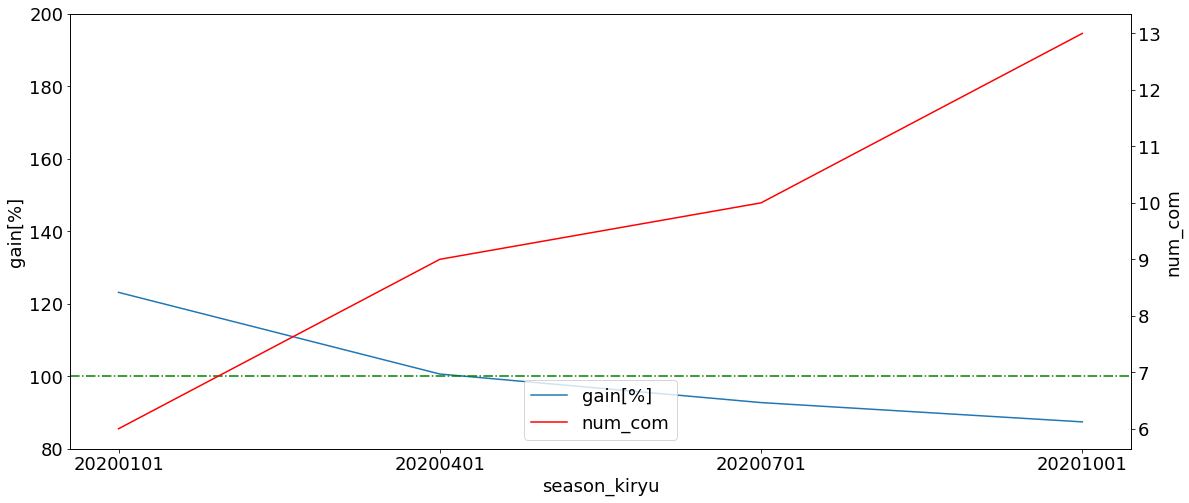

 10%|████████▎                                                                          | 1/10 [00:00<00:01,  6.24it/s]

place_name: toda ========================================================================================
../../bot_database/toda/model_score_toda/use_model/V4_2/use_model_toda_20200101_V4_2.csv
../../bot_database/toda/model_score_toda/use_model/V4_2/use_model_toda_20200401_V4_2.csv
../../bot_database/toda/model_score_toda/use_model/V4_2/use_model_toda_20200701_V4_2.csv
../../bot_database/toda/model_score_toda/use_model/V4_2/use_model_toda_20201001_V4_2.csv


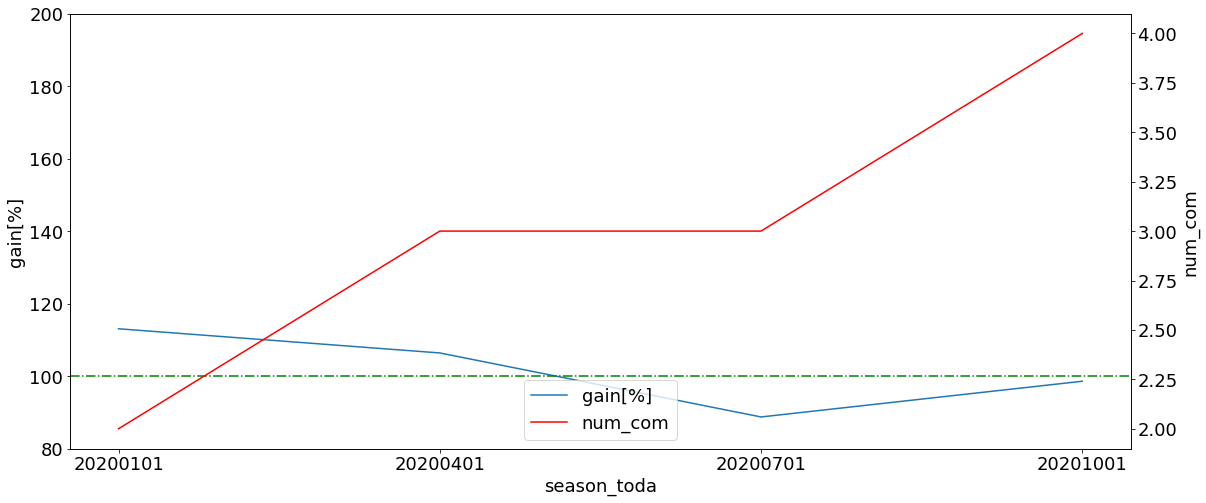

 20%|████████████████▌                                                                  | 2/10 [00:00<00:01,  6.30it/s]

place_name: edogawa ========================================================================================
../../bot_database/edogawa/model_score_edogawa/use_model/V4_2/use_model_edogawa_20200101_V4_2.csv
../../bot_database/edogawa/model_score_edogawa/use_model/V4_2/use_model_edogawa_20200401_V4_2.csv
../../bot_database/edogawa/model_score_edogawa/use_model/V4_2/use_model_edogawa_20200701_V4_2.csv
../../bot_database/edogawa/model_score_edogawa/use_model/V4_2/use_model_edogawa_20201001_V4_2.csv


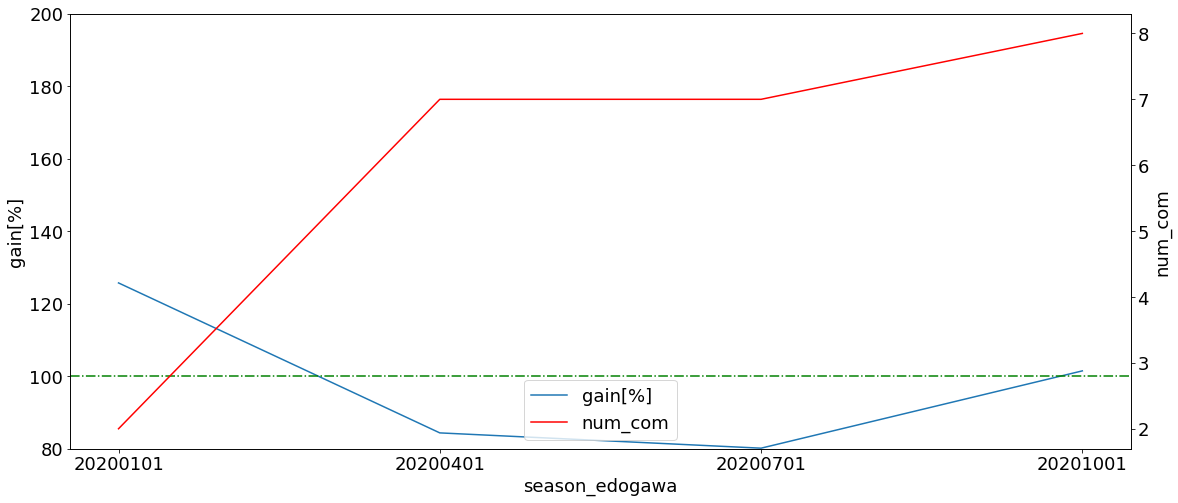

 30%|████████████████████████▉                                                          | 3/10 [00:00<00:01,  6.20it/s]

place_name: heiwazima ========================================================================================
../../bot_database/heiwazima/model_score_heiwazima/use_model/V4_2/use_model_heiwazima_20200101_V4_2.csv
../../bot_database/heiwazima/model_score_heiwazima/use_model/V4_2/use_model_heiwazima_20200401_V4_2.csv
../../bot_database/heiwazima/model_score_heiwazima/use_model/V4_2/use_model_heiwazima_20200701_V4_2.csv
../../bot_database/heiwazima/model_score_heiwazima/use_model/V4_2/use_model_heiwazima_20201001_V4_2.csv


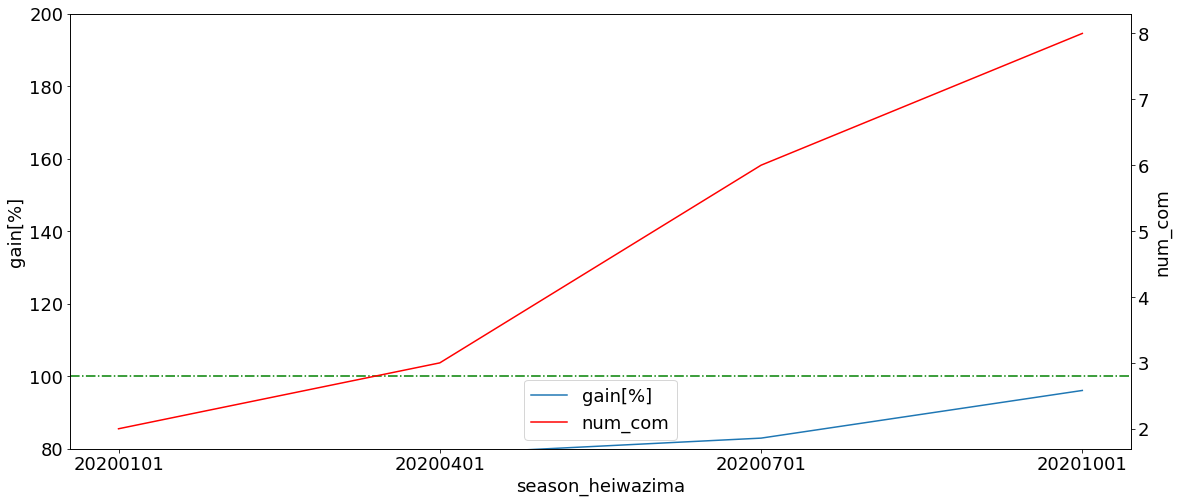

 40%|█████████████████████████████████▏                                                 | 4/10 [00:00<00:01,  5.40it/s]

place_name: tamagawa ========================================================================================
../../bot_database/tamagawa/model_score_tamagawa/use_model/V4_2/use_model_tamagawa_20200101_V4_2.csv
../../bot_database/tamagawa/model_score_tamagawa/use_model/V4_2/use_model_tamagawa_20200401_V4_2.csv
../../bot_database/tamagawa/model_score_tamagawa/use_model/V4_2/use_model_tamagawa_20200701_V4_2.csv
../../bot_database/tamagawa/model_score_tamagawa/use_model/V4_2/use_model_tamagawa_20201001_V4_2.csv


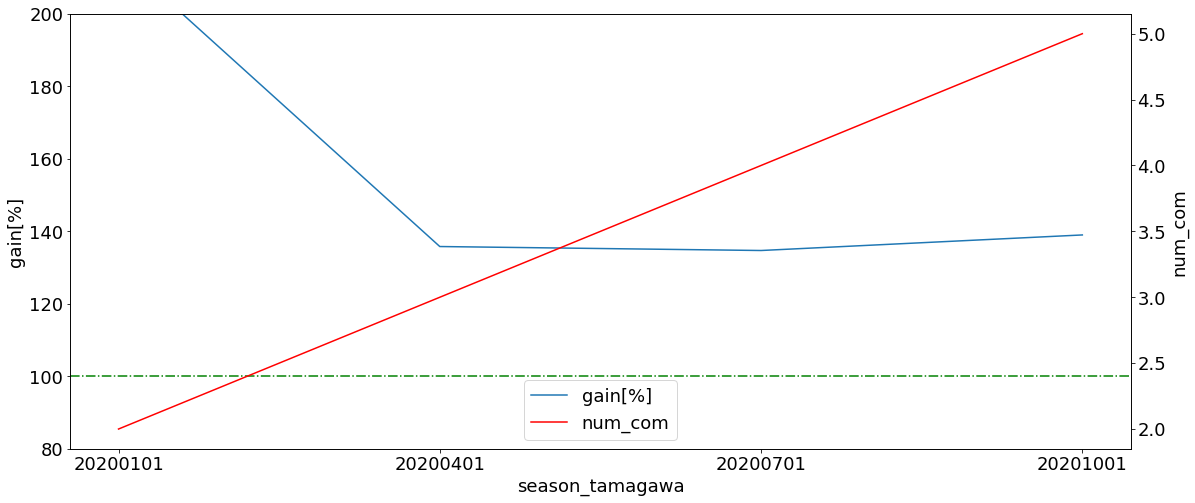

 50%|█████████████████████████████████████████▌                                         | 5/10 [00:00<00:00,  5.67it/s]

place_name: hamanako ========================================================================================
../../bot_database/hamanako/model_score_hamanako/use_model/V4_2/use_model_hamanako_20200101_V4_2.csv
../../bot_database/hamanako/model_score_hamanako/use_model/V4_2/use_model_hamanako_20200401_V4_2.csv
../../bot_database/hamanako/model_score_hamanako/use_model/V4_2/use_model_hamanako_20200701_V4_2.csv
../../bot_database/hamanako/model_score_hamanako/use_model/V4_2/use_model_hamanako_20201001_V4_2.csv


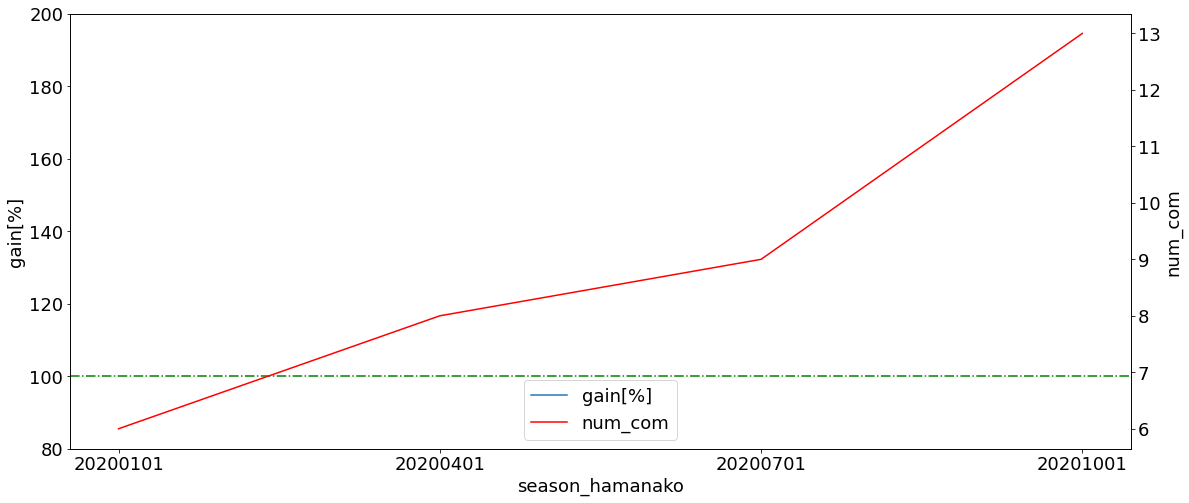

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:01<00:00,  5.72it/s]

place_name: gamagori ========================================================================================
../../bot_database/gamagori/model_score_gamagori/use_model/V4_2/use_model_gamagori_20200101_V4_2.csv
../../bot_database/gamagori/model_score_gamagori/use_model/V4_2/use_model_gamagori_20200401_V4_2.csv
../../bot_database/gamagori/model_score_gamagori/use_model/V4_2/use_model_gamagori_20200701_V4_2.csv
../../bot_database/gamagori/model_score_gamagori/use_model/V4_2/use_model_gamagori_20201001_V4_2.csv


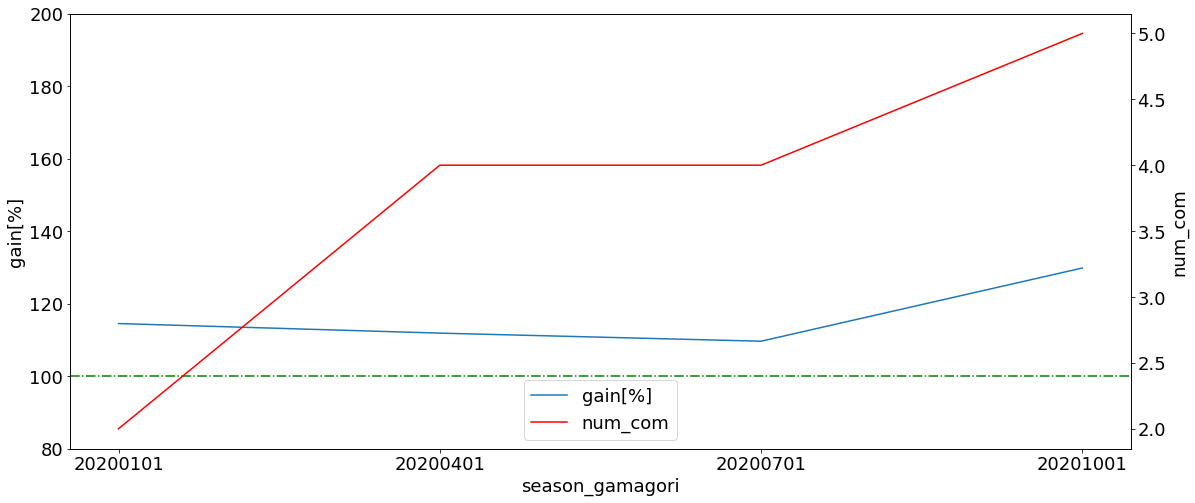

 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:01<00:00,  5.79it/s]

place_name: tokoname ========================================================================================
../../bot_database/tokoname/model_score_tokoname/use_model/V4_2/use_model_tokoname_20200101_V4_2.csv
../../bot_database/tokoname/model_score_tokoname/use_model/V4_2/use_model_tokoname_20200401_V4_2.csv
../../bot_database/tokoname/model_score_tokoname/use_model/V4_2/use_model_tokoname_20200701_V4_2.csv
../../bot_database/tokoname/model_score_tokoname/use_model/V4_2/use_model_tokoname_20201001_V4_2.csv


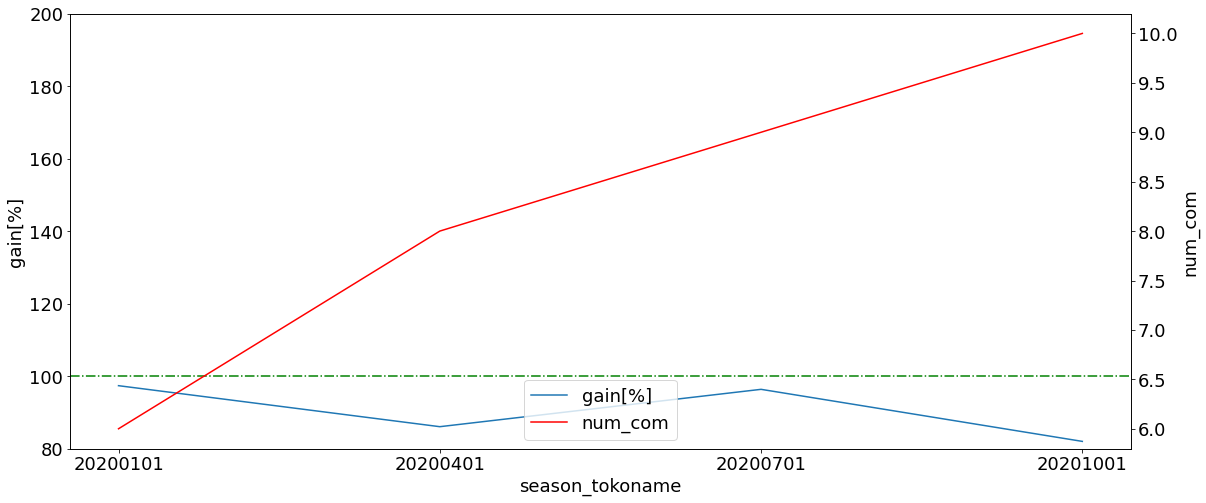

 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:01<00:00,  5.81it/s]

place_name: tu ========================================================================================
../../bot_database/tu/model_score_tu/use_model/V4_2/use_model_tu_20200101_V4_2.csv
../../bot_database/tu/model_score_tu/use_model/V4_2/use_model_tu_20200401_V4_2.csv
../../bot_database/tu/model_score_tu/use_model/V4_2/use_model_tu_20200701_V4_2.csv
../../bot_database/tu/model_score_tu/use_model/V4_2/use_model_tu_20201001_V4_2.csv


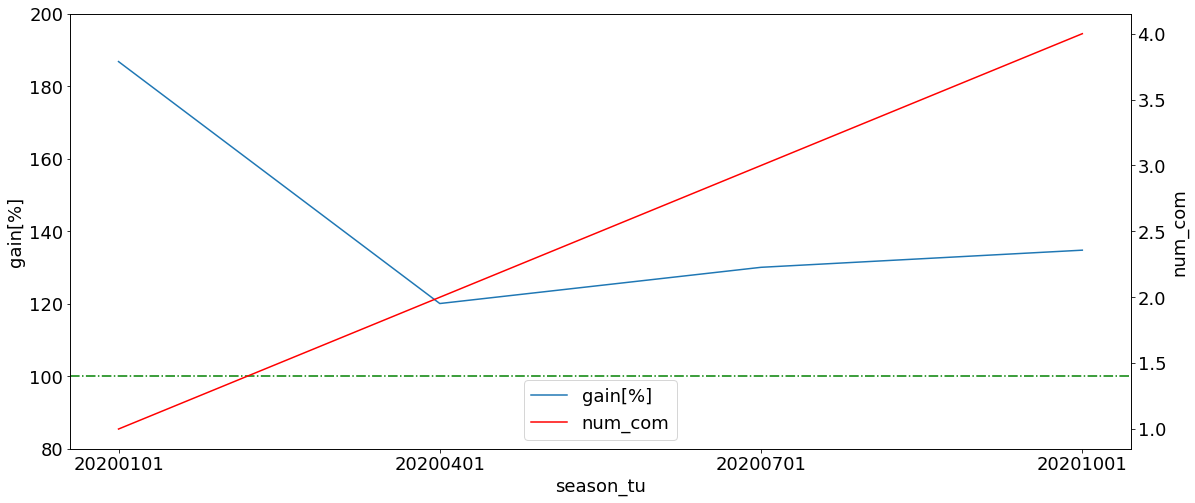

 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:01<00:00,  5.83it/s]

place_name: mikuni ========================================================================================
../../bot_database/mikuni/model_score_mikuni/use_model/V4_2/use_model_mikuni_20200101_V4_2.csv
../../bot_database/mikuni/model_score_mikuni/use_model/V4_2/use_model_mikuni_20200401_V4_2.csv
../../bot_database/mikuni/model_score_mikuni/use_model/V4_2/use_model_mikuni_20200701_V4_2.csv
../../bot_database/mikuni/model_score_mikuni/use_model/V4_2/use_model_mikuni_20201001_V4_2.csv


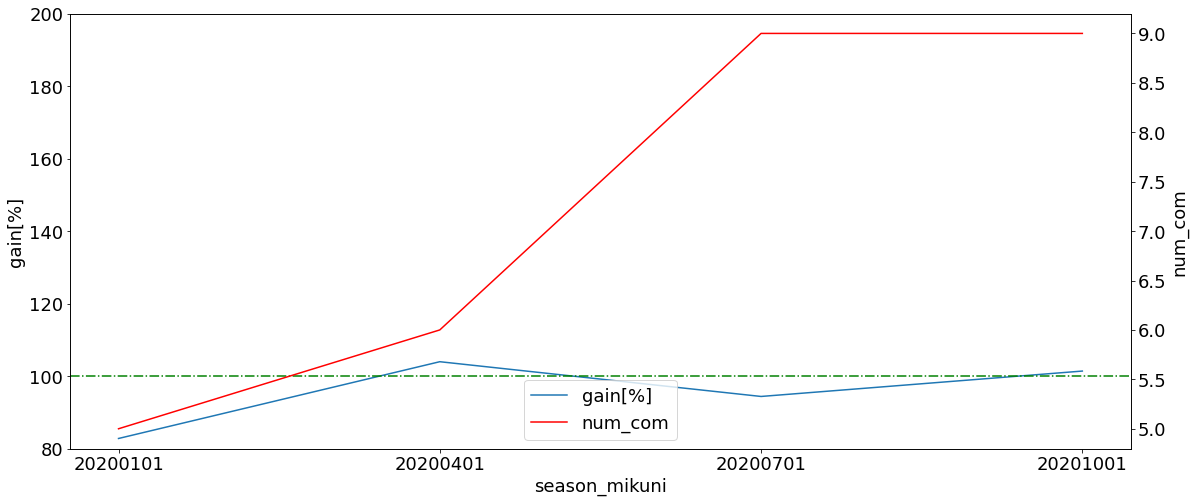

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.81it/s]


In [83]:

version='V4_2'
for place_name in tqdm(place_names[:10]):
    print('place_name:',place_name,'========================================================================================')
    gain_arr=[0]*4
    n_com_arr=[0]*4
    date_arr=[0]*4
    for i in range(4):
        now_ym=datetime.datetime(year=2020, month=1+(i*3),day=1).strftime('%Y%m%d')
        dir_path = "../../bot_database/{place_name}/model_score_{place_name}/use_model/{version}/use_model_{place_name}_{now_ym}_{version}.csv".format(place_name=place_name,version=version,now_ym=now_ym)#作成したデータの書き込み先#使用するデータの読み込み
        print(dir_path)
        use_models=pd.read_csv(dir_path, encoding='utf_8_sig')
        s_t_use=use_models['total_use_final'].sum()
        s_t_get=use_models['total_get_final'].sum()
        s_gain=(s_t_get/s_t_use)*100
        gain_arr[i]=s_gain
        n_com_arr[i]=len(use_models)
        date_arr[i]=now_ym
    x_n='season_{place_name}'.format(place_name=place_name)
    y1_n='gain[%]'
    y2_n='num_com'
    twin_plt(date_arr,gain_arr,n_com_arr,x_n,y1_n,y2_n)

# 全会場版なのは変わらず，相関係数の算出部分を変更した

In [36]:
#相関係数と全体分析の結果をもとに最終的に使用するモデルを選定する
place_master=master.get_place_master()
place_names=[place_name for place_name in place_master.values()]#会場名のみを収納した配列
#絶対に固定のパラメータたち
plus_m_th=2
#plus_m_th=3
num_hit_th=5
version='V4_2'
mode='model_score_'
mode_type='recent'
#コード本文
for place_name in tqdm(place_names[:10]):
    csv_path='../../bot_database/{place_name}/model_score_{place_name}/v4_score/{version}/{version}_{mode_type}_TRhit_pM{plus_month}_total_analysis.csv'.format(place_name=place_name,mode_type=mode_type,version=version,plus_month=plus_m_th,num_hit=num_hit_th)
    totol_analysis_df=pd.read_csv(csv_path, encoding='utf_8_sig')
    totol_analysis_df=totol_analysis_df.drop(["Unnamed: 0"],axis=1)
    print('place_name:',place_name,'========================================================================================')
    #閾値の取得
    th_s=totol_analysis_df[totol_analysis_df['num_plus_com_mean']>2].sort_values('minus_model_per_mean').iloc[0]#plusだったcom数の平均が２より大きい
    #th_s=totol_analysis_df[totol_analysis_df['num_plus_com_mean']>3].sort_values('minus_model_per_mean').iloc[0]#plusだったcom数の平均が２より大きい
    print(th_s)
    dates=[datetime.datetime(year=2020, month=1+(i*3),day=1).strftime('%Y%m%d') for i in range(4)]#今回のテストで使用する日付たち
    select_model_df=pd.DataFrame()
    
    #閾値にあてはまった　モデルたちがどんな奴らなのかを確認する
    for i in range(4):
        now_ym=datetime.datetime(year=2020, month=1+(i*3),day=1).strftime('%Y%m%d')
        #print('now_date:',now_ym)
        dir_path='../../bot_database/{place_name}/model_score_{place_name}/v4_score/{version}/{place_name}_{mode}st{now_ym}_finalM3_{version}.csv'.format(place_name=place_name,mode=mode,now_ym=now_ym,version=version)
        model_score_df=pd.read_csv(dir_path, encoding='utf_8_sig')
        model_score_df=model_score_df.drop(["Unnamed: 0"],axis=1)
        #選定したパラメータで切り落とし
        selected_m=model_score_df[model_score_df['gain_test']>=th_s["gain_th"]].copy()
        selected_m=selected_m[selected_m['gain_std_test']<=th_s["gain_std_th"]].copy()
        selected_m=selected_m[selected_m['buy_hit_per_test']>=th_s["hit_per_th"]].copy()
        selected_m=selected_m[selected_m['buy_hit_per_std_test']<=th_s["hit_std_th"]].copy()
        selected_m=selected_m[selected_m['num_hit_test']>=th_s["num_hit_th"]].copy()#的中した予測の数で切り捨てる,これも可変していく方針に変更した
        select_model_df=pd.concat([select_model_df, selected_m], axis=0)#きめのパラメータで切り落としたので結合
        
        
        #偏差値評価を用いた実際に使用するモデルの切り抜き(方針：使用する区間の１つ前の区間(test5,final3の区間))をもとに相関係数を算出
        #試しに一年間の相関係数を加算してみる
        feature_weights=pd.Series(dtype='object')
        for i_2 in range(4):
            i2_now_ym=datetime.datetime(year=2020, month=1+(i_2*3),day=1).strftime('%Y%m%d')
            use_date=dates[i-1]#一つ前の区間の日付を切り抜く
            dir_path='../../bot_database/{place_name}/model_score_{place_name}/v4_score/{version}/{place_name}_{mode}st{now_ym}_finalM3_{version}.csv'.format(place_name=place_name,mode=mode,now_ym=i2_now_ym,version=version)
            #print(dir_path)
            model_score_df=pd.read_csv(dir_path, encoding='utf_8_sig')
            model_score_df=model_score_df.drop(["Unnamed: 0"],axis=1)
            #決めのパラメータでいったん切り落とし
            model_score_df=model_score_df[model_score_df['plus_month_num_test']>=plus_m_th].copy()#収益がプラスだった月の数で切り捨てる
            model_score_df=model_score_df[model_score_df['num_hit_test']>=num_hit_th].copy()#的中した予測の数で切り捨てる，大体一カ月に一件くらいをイメージ
            version_corr_df=model_score_df.corr()
            if len(feature_weights)==0:
                feature_weights=version_corr_df.loc['gain_final']['total_get_test':'diff_mea_med_test']#相関係数を代用した変数ごとの重みづけ
            else:
                feature_weights=feature_weights+version_corr_df.loc['gain_final']['total_get_test':'diff_mea_med_test']#相関係数を代用した変数ごとの重みづけ
        display(feature_weights)
        model_std_score_df=add_std_score(select_model_df,feature_weights)


        use_models=select_use_model(model_std_score_df)#相関係数と標準偏差によって与えられたscoreをもとに最終的に使用するモデルを選定する関数
        dir_path = "../../bot_database/{place_name}/model_score_{place_name}/use_model/{version}/use_model_{place_name}_{now_ym}_{version}.csv".format(place_name=place_name,version=version,now_ym=now_ym)#作成したデータの書き込み先#使用するデータの読み込み
        use_models.to_csv(dir_path)

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

place_name: kiryu ========================================================================================
minus_model_per_mean                62.135142
num_plus_com_mean                    4.750000
num_plus_model_mean                122.250000
gain_th                            100.000000
gain_std_th                        130.000000
hit_per_th                           0.000000
hit_std_th                           0.400000
num_hit_th                           3.000000
st_20200101_minus_per(model)        47.596154
st_20200101_num_plus_com            10.000000
st_20200101_num_plus_model(row)    218.000000
st_20200401_minus_per(model)        66.855524
st_20200401_num_plus_com             2.000000
st_20200401_num_plus_model(row)    117.000000
st_20200701_minus_per(model)        77.200000
st_20200701_num_plus_com             5.000000
st_20200701_num_plus_model(row)     57.000000
st_20201001_minus_per(model)        56.888889
st_20201001_num_plus_com             2.000000
st_20201001_num_plu

total_get_test         -0.199499
total_use_test         -0.169587
num_com_test           -0.319226
num_pred_test          -0.169587
gain_test               0.150332
gain_std_test           0.212400
num_hit_test           -0.028224
buy_hit_per_test        0.303588
buy_hit_per_std_test    0.184035
plus_month_num_test    -0.143254
diff_mea_med_test       0.119044
Name: gain_final, dtype: float64

c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

total_get_test         -0.199499
total_use_test         -0.169587
num_com_test           -0.319226
num_pred_test          -0.169587
gain_test               0.150332
gain_std_test           0.212400
num_hit_test           -0.028224
buy_hit_per_test        0.303588
buy_hit_per_std_test    0.184035
plus_month_num_test    -0.143254
diff_mea_med_test       0.119044
Name: gain_final, dtype: float64

c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

total_get_test         -0.199499
total_use_test         -0.169587
num_com_test           -0.319226
num_pred_test          -0.169587
gain_test               0.150332
gain_std_test           0.212400
num_hit_test           -0.028224
buy_hit_per_test        0.303588
buy_hit_per_std_test    0.184035
plus_month_num_test    -0.143254
diff_mea_med_test       0.119044
Name: gain_final, dtype: float64

c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

total_get_test         -0.199499
total_use_test         -0.169587
num_com_test           -0.319226
num_pred_test          -0.169587
gain_test               0.150332
gain_std_test           0.212400
num_hit_test           -0.028224
buy_hit_per_test        0.303588
buy_hit_per_std_test    0.184035
plus_month_num_test    -0.143254
diff_mea_med_test       0.119044
Name: gain_final, dtype: float64

c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

place_name: toda ========================================================================================
minus_model_per_mean               16.954685
num_plus_com_mean                   2.250000
num_plus_model_mean                20.750000
gain_th                            96.000000
gain_std_th                        85.000000
hit_per_th                          6.000000
hit_std_th                          1.600000
num_hit_th                          5.000000
st_20200101_minus_per(model)        9.523810
st_20200101_num_plus_com            3.000000
st_20200101_num_plus_model(row)    38.000000
st_20200401_minus_per(model)       35.714286
st_20200401_num_plus_com            2.000000
st_20200401_num_plus_model(row)     9.000000
st_20200701_minus_per(model)       22.580645
st_20200701_num_plus_com            2.000000
st_20200701_num_plus_model(row)    24.000000
st_20201001_minus_per(model)        0.000000
st_20201001_num_plus_com            2.000000
st_20201001_num_plus_model(row)    12.0

total_get_test          0.444585
total_use_test         -0.072224
num_com_test            0.182171
num_pred_test          -0.072224
gain_test               0.541819
gain_std_test           0.699223
num_hit_test            0.123422
buy_hit_per_test        0.187444
buy_hit_per_std_test    0.516411
plus_month_num_test    -0.448235
diff_mea_med_test      -0.137910
Name: gain_final, dtype: float64

c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

total_get_test          0.444585
total_use_test         -0.072224
num_com_test            0.182171
num_pred_test          -0.072224
gain_test               0.541819
gain_std_test           0.699223
num_hit_test            0.123422
buy_hit_per_test        0.187444
buy_hit_per_std_test    0.516411
plus_month_num_test    -0.448235
diff_mea_med_test      -0.137910
Name: gain_final, dtype: float64

c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

total_get_test          0.444585
total_use_test         -0.072224
num_com_test            0.182171
num_pred_test          -0.072224
gain_test               0.541819
gain_std_test           0.699223
num_hit_test            0.123422
buy_hit_per_test        0.187444
buy_hit_per_std_test    0.516411
plus_month_num_test    -0.448235
diff_mea_med_test      -0.137910
Name: gain_final, dtype: float64

c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

total_get_test          0.444585
total_use_test         -0.072224
num_com_test            0.182171
num_pred_test          -0.072224
gain_test               0.541819
gain_std_test           0.699223
num_hit_test            0.123422
buy_hit_per_test        0.187444
buy_hit_per_std_test    0.516411
plus_month_num_test    -0.448235
diff_mea_med_test      -0.137910
Name: gain_final, dtype: float64

c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

place_name: edogawa ========================================================================================
minus_model_per_mean                30.134409
num_plus_com_mean                    2.250000
num_plus_model_mean                 12.250000
gain_th                            160.000000
gain_std_th                        190.000000
hit_per_th                           4.000000
hit_std_th                           1.200000
num_hit_th                           5.000000
st_20200101_minus_per(model)        36.666667
st_20200101_num_plus_com             3.000000
st_20200101_num_plus_model(row)     19.000000
st_20200401_minus_per(model)        83.870968
st_20200401_num_plus_com             4.000000
st_20200401_num_plus_model(row)     25.000000
st_20200701_minus_per(model)         0.000000
st_20200701_num_plus_com             1.000000
st_20200701_num_plus_model(row)      1.000000
st_20201001_minus_per(model)         0.000000
st_20201001_num_plus_com             1.000000
st_20201001_num_p

total_get_test         -0.038820
total_use_test         -0.590285
num_com_test           -0.703417
num_pred_test          -0.590285
gain_test               0.838846
gain_std_test           0.886224
num_hit_test           -0.679503
buy_hit_per_test       -0.261587
buy_hit_per_std_test    0.106131
plus_month_num_test     0.381183
diff_mea_med_test      -0.390508
Name: gain_final, dtype: float64

c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

total_get_test         -0.038820
total_use_test         -0.590285
num_com_test           -0.703417
num_pred_test          -0.590285
gain_test               0.838846
gain_std_test           0.886224
num_hit_test           -0.679503
buy_hit_per_test       -0.261587
buy_hit_per_std_test    0.106131
plus_month_num_test     0.381183
diff_mea_med_test      -0.390508
Name: gain_final, dtype: float64

c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

total_get_test         -0.038820
total_use_test         -0.590285
num_com_test           -0.703417
num_pred_test          -0.590285
gain_test               0.838846
gain_std_test           0.886224
num_hit_test           -0.679503
buy_hit_per_test       -0.261587
buy_hit_per_std_test    0.106131
plus_month_num_test     0.381183
diff_mea_med_test      -0.390508
Name: gain_final, dtype: float64

c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

total_get_test         -0.038820
total_use_test         -0.590285
num_com_test           -0.703417
num_pred_test          -0.590285
gain_test               0.838846
gain_std_test           0.886224
num_hit_test           -0.679503
buy_hit_per_test       -0.261587
buy_hit_per_std_test    0.106131
plus_month_num_test     0.381183
diff_mea_med_test      -0.390508
Name: gain_final, dtype: float64

c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

place_name: heiwazima ========================================================================================
minus_model_per_mean                49.935985
num_plus_com_mean                    2.500000
num_plus_model_mean                 23.000000
gain_th                            160.000000
gain_std_th                        190.000000
hit_per_th                           2.000000
hit_std_th                           0.800000
num_hit_th                           8.000000
st_20200101_minus_per(model)        85.416667
st_20200101_num_plus_com             2.000000
st_20200101_num_plus_model(row)      7.000000
st_20200401_minus_per(model)         0.000000
st_20200401_num_plus_com             2.000000
st_20200401_num_plus_model(row)      9.000000
st_20200701_minus_per(model)        72.727273
st_20200701_num_plus_com             2.000000
st_20200701_num_plus_model(row)      3.000000
st_20201001_minus_per(model)        41.600000
st_20201001_num_plus_com             4.000000
st_20201001_num

total_get_test         -0.233622
total_use_test          0.137883
num_com_test           -0.007817
num_pred_test           0.137883
gain_test              -0.450215
gain_std_test          -0.065186
num_hit_test            0.172557
buy_hit_per_test       -0.098639
buy_hit_per_std_test    0.450254
plus_month_num_test    -0.056401
diff_mea_med_test      -0.524796
Name: gain_final, dtype: float64

c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

total_get_test         -0.233622
total_use_test          0.137883
num_com_test           -0.007817
num_pred_test           0.137883
gain_test              -0.450215
gain_std_test          -0.065186
num_hit_test            0.172557
buy_hit_per_test       -0.098639
buy_hit_per_std_test    0.450254
plus_month_num_test    -0.056401
diff_mea_med_test      -0.524796
Name: gain_final, dtype: float64

c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

total_get_test         -0.233622
total_use_test          0.137883
num_com_test           -0.007817
num_pred_test           0.137883
gain_test              -0.450215
gain_std_test          -0.065186
num_hit_test            0.172557
buy_hit_per_test       -0.098639
buy_hit_per_std_test    0.450254
plus_month_num_test    -0.056401
diff_mea_med_test      -0.524796
Name: gain_final, dtype: float64

c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

total_get_test         -0.233622
total_use_test          0.137883
num_com_test           -0.007817
num_pred_test           0.137883
gain_test              -0.450215
gain_std_test          -0.065186
num_hit_test            0.172557
buy_hit_per_test       -0.098639
buy_hit_per_std_test    0.450254
plus_month_num_test    -0.056401
diff_mea_med_test      -0.524796
Name: gain_final, dtype: float64

c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

place_name: tamagawa ========================================================================================
minus_model_per_mean                35.136901
num_plus_com_mean                    2.500000
num_plus_model_mean                 52.250000
gain_th                            108.000000
gain_std_th                        115.000000
hit_per_th                           6.000000
hit_std_th                           1.200000
num_hit_th                           8.000000
st_20200101_minus_per(model)         0.000000
st_20200101_num_plus_com             3.000000
st_20200101_num_plus_model(row)    109.000000
st_20200401_minus_per(model)        92.721519
st_20200401_num_plus_com             2.000000
st_20200401_num_plus_model(row)     23.000000
st_20200701_minus_per(model)        47.826087
st_20200701_num_plus_com             4.000000
st_20200701_num_plus_model(row)     72.000000
st_20201001_minus_per(model)         0.000000
st_20201001_num_plus_com             1.000000
st_20201001_num_

total_get_test          0.013531
total_use_test         -0.334015
num_com_test            0.641679
num_pred_test          -0.334015
gain_test               0.291239
gain_std_test           0.060250
num_hit_test            0.561686
buy_hit_per_test        0.889105
buy_hit_per_std_test    0.680484
plus_month_num_test     0.327890
diff_mea_med_test       0.168735
Name: gain_final, dtype: float64

c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

total_get_test          0.013531
total_use_test         -0.334015
num_com_test            0.641679
num_pred_test          -0.334015
gain_test               0.291239
gain_std_test           0.060250
num_hit_test            0.561686
buy_hit_per_test        0.889105
buy_hit_per_std_test    0.680484
plus_month_num_test     0.327890
diff_mea_med_test       0.168735
Name: gain_final, dtype: float64

c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

total_get_test          0.013531
total_use_test         -0.334015
num_com_test            0.641679
num_pred_test          -0.334015
gain_test               0.291239
gain_std_test           0.060250
num_hit_test            0.561686
buy_hit_per_test        0.889105
buy_hit_per_std_test    0.680484
plus_month_num_test     0.327890
diff_mea_med_test       0.168735
Name: gain_final, dtype: float64

c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

total_get_test          0.013531
total_use_test         -0.334015
num_com_test            0.641679
num_pred_test          -0.334015
gain_test               0.291239
gain_std_test           0.060250
num_hit_test            0.561686
buy_hit_per_test        0.889105
buy_hit_per_std_test    0.680484
plus_month_num_test     0.327890
diff_mea_med_test       0.168735
Name: gain_final, dtype: float64

c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

place_name: hamanako ========================================================================================
minus_model_per_mean                51.939811
num_plus_com_mean                    2.250000
num_plus_model_mean                 24.750000
gain_th                            124.000000
gain_std_th                        235.000000
hit_per_th                           2.000000
hit_std_th                           0.800000
num_hit_th                           8.000000
st_20200101_minus_per(model)        28.571429
st_20200101_num_plus_com             4.000000
st_20200101_num_plus_model(row)     55.000000
st_20200401_minus_per(model)       100.000000
st_20200401_num_plus_com             0.000000
st_20200401_num_plus_model(row)      0.000000
st_20200701_minus_per(model)         0.000000
st_20200701_num_plus_com             1.000000
st_20200701_num_plus_model(row)      3.000000
st_20201001_minus_per(model)        79.187817
st_20201001_num_plus_com             4.000000
st_20201001_num_

total_get_test         -0.119075
total_use_test          0.320847
num_com_test            0.859892
num_pred_test           0.320847
gain_test              -0.691921
gain_std_test          -0.392178
num_hit_test            0.603468
buy_hit_per_test        0.190974
buy_hit_per_std_test   -0.388838
plus_month_num_test    -0.307649
diff_mea_med_test       0.288410
Name: gain_final, dtype: float64

c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

total_get_test         -0.119075
total_use_test          0.320847
num_com_test            0.859892
num_pred_test           0.320847
gain_test              -0.691921
gain_std_test          -0.392178
num_hit_test            0.603468
buy_hit_per_test        0.190974
buy_hit_per_std_test   -0.388838
plus_month_num_test    -0.307649
diff_mea_med_test       0.288410
Name: gain_final, dtype: float64

c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

total_get_test         -0.119075
total_use_test          0.320847
num_com_test            0.859892
num_pred_test           0.320847
gain_test              -0.691921
gain_std_test          -0.392178
num_hit_test            0.603468
buy_hit_per_test        0.190974
buy_hit_per_std_test   -0.388838
plus_month_num_test    -0.307649
diff_mea_med_test       0.288410
Name: gain_final, dtype: float64

c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

total_get_test         -0.119075
total_use_test          0.320847
num_com_test            0.859892
num_pred_test           0.320847
gain_test              -0.691921
gain_std_test          -0.392178
num_hit_test            0.603468
buy_hit_per_test        0.190974
buy_hit_per_std_test   -0.388838
plus_month_num_test    -0.307649
diff_mea_med_test       0.288410
Name: gain_final, dtype: float64

c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

place_name: gamagori ========================================================================================
minus_model_per_mean                33.069829
num_plus_com_mean                    2.250000
num_plus_model_mean                 48.000000
gain_th                            108.000000
gain_std_th                        130.000000
hit_per_th                           6.000000
hit_std_th                           1.200000
num_hit_th                           5.000000
st_20200101_minus_per(model)        23.188406
st_20200101_num_plus_com             4.000000
st_20200101_num_plus_model(row)    159.000000
st_20200401_minus_per(model)         9.090909
st_20200401_num_plus_com             4.000000
st_20200401_num_plus_model(row)     30.000000
st_20200701_minus_per(model)       100.000000
st_20200701_num_plus_com             0.000000
st_20200701_num_plus_model(row)      0.000000
st_20201001_minus_per(model)         0.000000
st_20201001_num_plus_com             1.000000
st_20201001_num_

total_get_test         -0.286843
total_use_test         -0.100707
num_com_test            0.751395
num_pred_test          -0.100707
gain_test              -0.203944
gain_std_test          -0.462961
num_hit_test            0.537698
buy_hit_per_test        0.773013
buy_hit_per_std_test    0.728936
plus_month_num_test    -0.258555
diff_mea_med_test       0.154562
Name: gain_final, dtype: float64

c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

total_get_test         -0.286843
total_use_test         -0.100707
num_com_test            0.751395
num_pred_test          -0.100707
gain_test              -0.203944
gain_std_test          -0.462961
num_hit_test            0.537698
buy_hit_per_test        0.773013
buy_hit_per_std_test    0.728936
plus_month_num_test    -0.258555
diff_mea_med_test       0.154562
Name: gain_final, dtype: float64

c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

total_get_test         -0.286843
total_use_test         -0.100707
num_com_test            0.751395
num_pred_test          -0.100707
gain_test              -0.203944
gain_std_test          -0.462961
num_hit_test            0.537698
buy_hit_per_test        0.773013
buy_hit_per_std_test    0.728936
plus_month_num_test    -0.258555
diff_mea_med_test       0.154562
Name: gain_final, dtype: float64

c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

total_get_test         -0.286843
total_use_test         -0.100707
num_com_test            0.751395
num_pred_test          -0.100707
gain_test              -0.203944
gain_std_test          -0.462961
num_hit_test            0.537698
buy_hit_per_test        0.773013
buy_hit_per_std_test    0.728936
plus_month_num_test    -0.258555
diff_mea_med_test       0.154562
Name: gain_final, dtype: float64

c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

place_name: tokoname ========================================================================================
minus_model_per_mean                39.015152
num_plus_com_mean                    2.250000
num_plus_model_mean                 22.000000
gain_th                            144.000000
gain_std_th                        160.000000
hit_per_th                           4.000000
hit_std_th                           1.600000
num_hit_th                           3.000000
st_20200101_minus_per(model)        39.393939
st_20200101_num_plus_com             5.000000
st_20200101_num_plus_model(row)     80.000000
st_20200401_minus_per(model)       100.000000
st_20200401_num_plus_com             0.000000
st_20200401_num_plus_model(row)      0.000000
st_20200701_minus_per(model)        16.666667
st_20200701_num_plus_com             2.000000
st_20200701_num_plus_model(row)      5.000000
st_20201001_minus_per(model)         0.000000
st_20201001_num_plus_com             2.000000
st_20201001_num_

total_get_test         -0.497590
total_use_test         -0.448235
num_com_test           -0.472621
num_pred_test          -0.448235
gain_test               0.035473
gain_std_test           0.045893
num_hit_test           -0.191550
buy_hit_per_test        0.180269
buy_hit_per_std_test    0.712396
plus_month_num_test    -0.041402
diff_mea_med_test      -0.235179
Name: gain_final, dtype: float64

c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

total_get_test         -0.497590
total_use_test         -0.448235
num_com_test           -0.472621
num_pred_test          -0.448235
gain_test               0.035473
gain_std_test           0.045893
num_hit_test           -0.191550
buy_hit_per_test        0.180269
buy_hit_per_std_test    0.712396
plus_month_num_test    -0.041402
diff_mea_med_test      -0.235179
Name: gain_final, dtype: float64

c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

total_get_test         -0.497590
total_use_test         -0.448235
num_com_test           -0.472621
num_pred_test          -0.448235
gain_test               0.035473
gain_std_test           0.045893
num_hit_test           -0.191550
buy_hit_per_test        0.180269
buy_hit_per_std_test    0.712396
plus_month_num_test    -0.041402
diff_mea_med_test      -0.235179
Name: gain_final, dtype: float64

c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

total_get_test         -0.497590
total_use_test         -0.448235
num_com_test           -0.472621
num_pred_test          -0.448235
gain_test               0.035473
gain_std_test           0.045893
num_hit_test           -0.191550
buy_hit_per_test        0.180269
buy_hit_per_std_test    0.712396
plus_month_num_test    -0.041402
diff_mea_med_test      -0.235179
Name: gain_final, dtype: float64

c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

place_name: tu ========================================================================================
minus_model_per_mean                26.960784
num_plus_com_mean                    2.250000
num_plus_model_mean                  7.000000
gain_th                            148.000000
gain_std_th                        175.000000
hit_per_th                           4.000000
hit_std_th                           1.600000
num_hit_th                           8.000000
st_20200101_minus_per(model)         0.000000
st_20200101_num_plus_com             1.000000
st_20200101_num_plus_model(row)      8.000000
st_20200401_minus_per(model)        41.666667
st_20200401_num_plus_com             3.000000
st_20200401_num_plus_model(row)      7.000000
st_20200701_minus_per(model)        41.176471
st_20200701_num_plus_com             3.000000
st_20200701_num_plus_model(row)     10.000000
st_20201001_minus_per(model)        25.000000
st_20201001_num_plus_com             2.000000
st_20201001_num_plus_m

total_get_test          0.594437
total_use_test          0.781170
num_com_test            0.264427
num_pred_test           0.781170
gain_test              -0.058443
gain_std_test          -0.217975
num_hit_test            0.503831
buy_hit_per_test        0.141368
buy_hit_per_std_test   -0.369007
plus_month_num_test    -0.127184
diff_mea_med_test       0.164520
Name: gain_final, dtype: float64

total_get_test          0.594437
total_use_test          0.781170
num_com_test            0.264427
num_pred_test           0.781170
gain_test              -0.058443
gain_std_test          -0.217975
num_hit_test            0.503831
buy_hit_per_test        0.141368
buy_hit_per_std_test   -0.369007
plus_month_num_test    -0.127184
diff_mea_med_test       0.164520
Name: gain_final, dtype: float64

c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

total_get_test          0.594437
total_use_test          0.781170
num_com_test            0.264427
num_pred_test           0.781170
gain_test              -0.058443
gain_std_test          -0.217975
num_hit_test            0.503831
buy_hit_per_test        0.141368
buy_hit_per_std_test   -0.369007
plus_month_num_test    -0.127184
diff_mea_med_test       0.164520
Name: gain_final, dtype: float64

c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

total_get_test          0.594437
total_use_test          0.781170
num_com_test            0.264427
num_pred_test           0.781170
gain_test              -0.058443
gain_std_test          -0.217975
num_hit_test            0.503831
buy_hit_per_test        0.141368
buy_hit_per_std_test   -0.369007
plus_month_num_test    -0.127184
diff_mea_med_test       0.164520
Name: gain_final, dtype: float64

c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

place_name: mikuni ========================================================================================
minus_model_per_mean               40.159193
num_plus_com_mean                   2.250000
num_plus_model_mean                20.000000
gain_th                            96.000000
gain_std_th                        70.000000
hit_per_th                          2.000000
hit_std_th                          0.800000
num_hit_th                         10.000000
st_20200101_minus_per(model)       53.571429
st_20200101_num_plus_com            1.000000
st_20200101_num_plus_model(row)    13.000000
st_20200401_minus_per(model)        0.000000
st_20200401_num_plus_com            1.000000
st_20200401_num_plus_model(row)     2.000000
st_20200701_minus_per(model)       90.163934
st_20200701_num_plus_com            3.000000
st_20200701_num_plus_model(row)     6.000000
st_20201001_minus_per(model)       16.901408
st_20201001_num_plus_com            4.000000
st_20201001_num_plus_model(row)    59

total_get_test         -0.286286
total_use_test          0.177957
num_com_test            0.942689
num_pred_test           0.177957
gain_test              -0.507062
gain_std_test          -0.454064
num_hit_test            0.662391
buy_hit_per_test        0.707016
buy_hit_per_std_test    0.750793
plus_month_num_test    -0.327601
diff_mea_med_test       0.620786
Name: gain_final, dtype: float64

c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

total_get_test         -0.286286
total_use_test          0.177957
num_com_test            0.942689
num_pred_test           0.177957
gain_test              -0.507062
gain_std_test          -0.454064
num_hit_test            0.662391
buy_hit_per_test        0.707016
buy_hit_per_std_test    0.750793
plus_month_num_test    -0.327601
diff_mea_med_test       0.620786
Name: gain_final, dtype: float64

c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

total_get_test         -0.286286
total_use_test          0.177957
num_com_test            0.942689
num_pred_test           0.177957
gain_test              -0.507062
gain_std_test          -0.454064
num_hit_test            0.662391
buy_hit_per_test        0.707016
buy_hit_per_std_test    0.750793
plus_month_num_test    -0.327601
diff_mea_med_test       0.620786
Name: gain_final, dtype: float64

c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

total_get_test         -0.286286
total_use_test          0.177957
num_com_test            0.942689
num_pred_test           0.177957
gain_test              -0.507062
gain_std_test          -0.454064
num_hit_test            0.662391
buy_hit_per_test        0.707016
buy_hit_per_std_test    0.750793
plus_month_num_test    -0.327601
diff_mea_med_test       0.620786
Name: gain_final, dtype: float64

c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]<ipython-input-2-6df26f47718d>:33: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


place_name: kiryu ========================================================================================


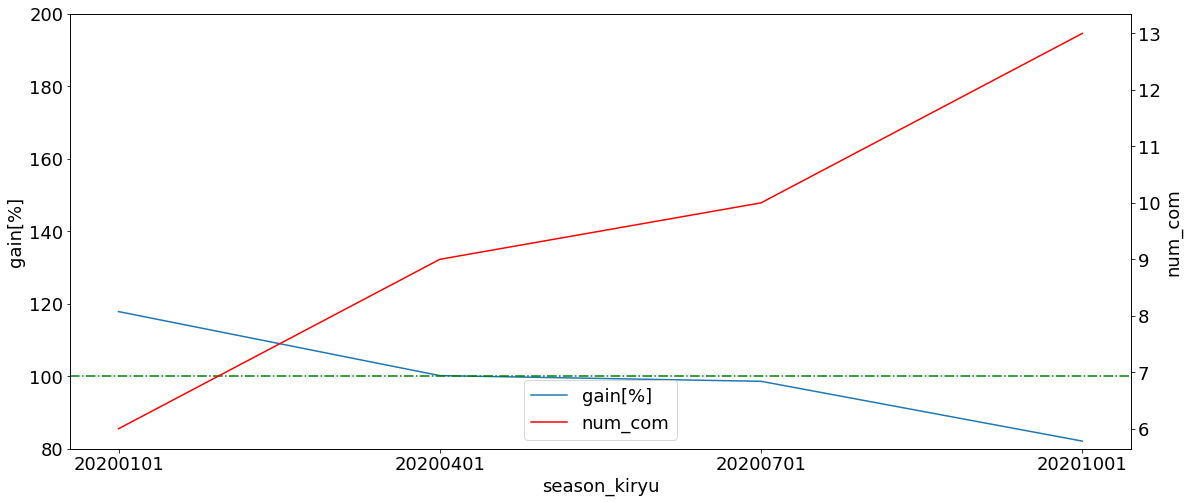

 10%|████████▎                                                                          | 1/10 [00:00<00:01,  4.63it/s]

place_name: toda ========================================================================================


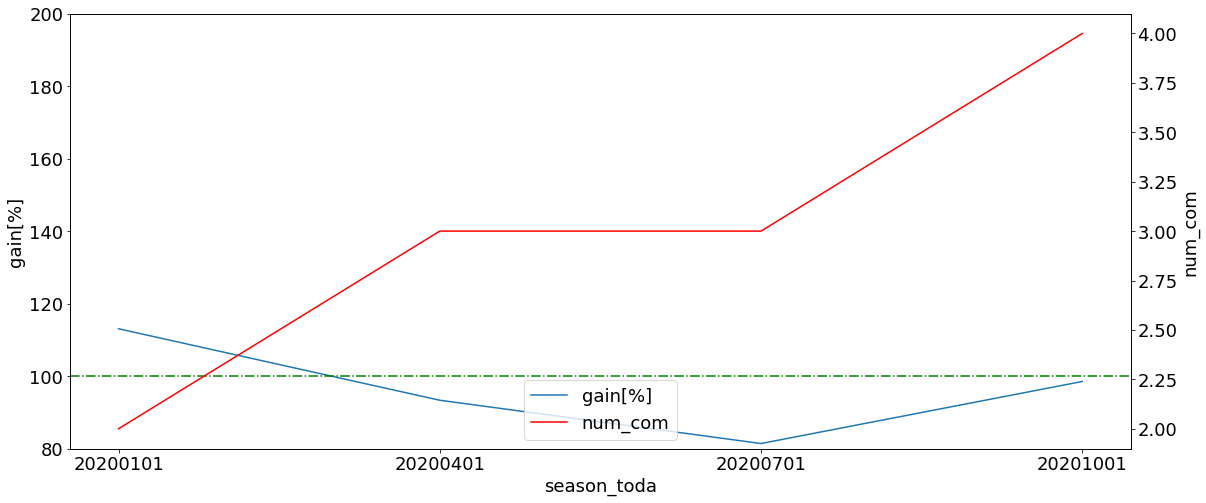

 20%|████████████████▌                                                                  | 2/10 [00:00<00:01,  5.59it/s]

place_name: edogawa ========================================================================================


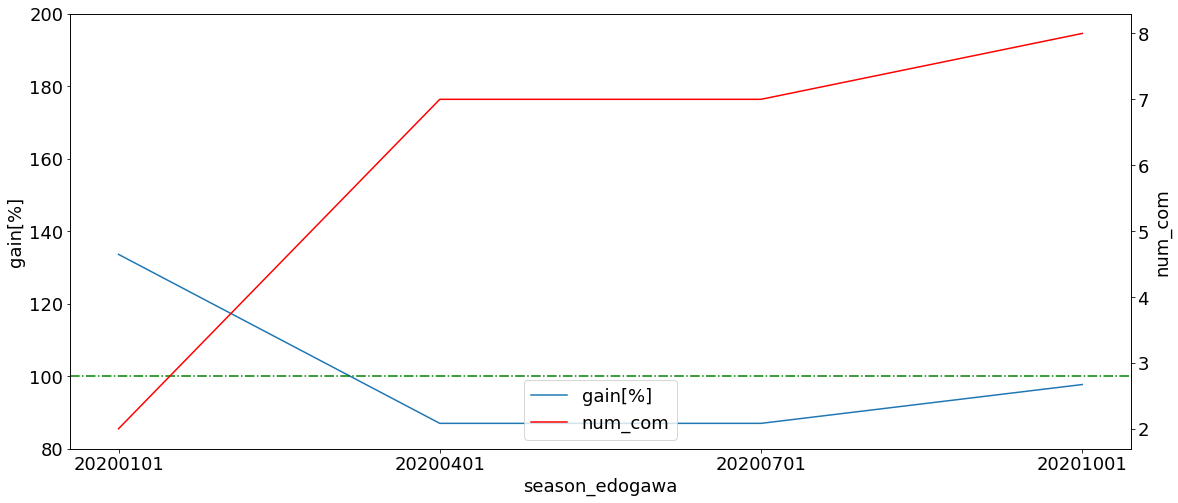

 30%|████████████████████████▉                                                          | 3/10 [00:00<00:01,  6.12it/s]

place_name: heiwazima ========================================================================================


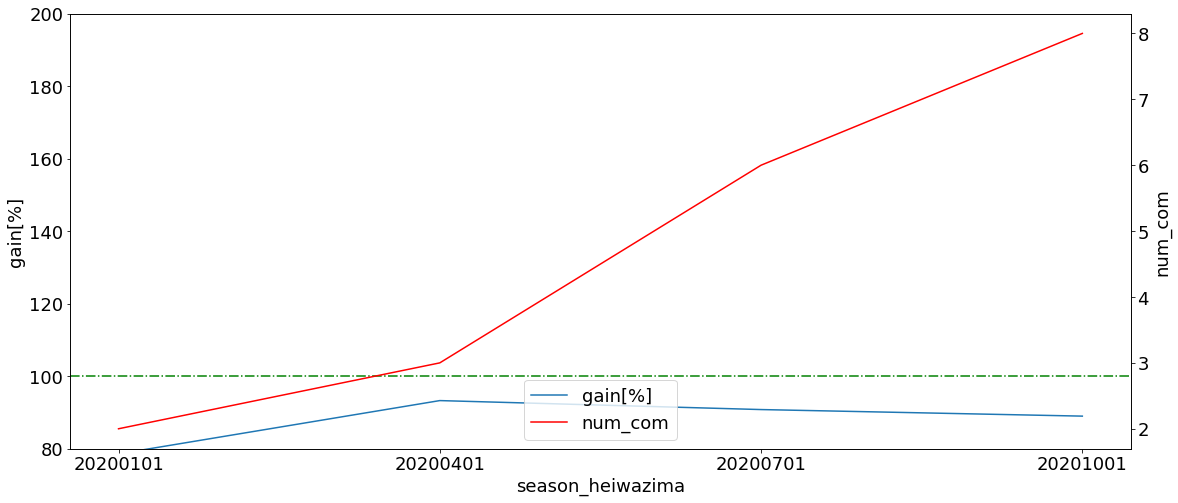

 40%|█████████████████████████████████▏                                                 | 4/10 [00:00<00:00,  6.38it/s]

place_name: tamagawa ========================================================================================


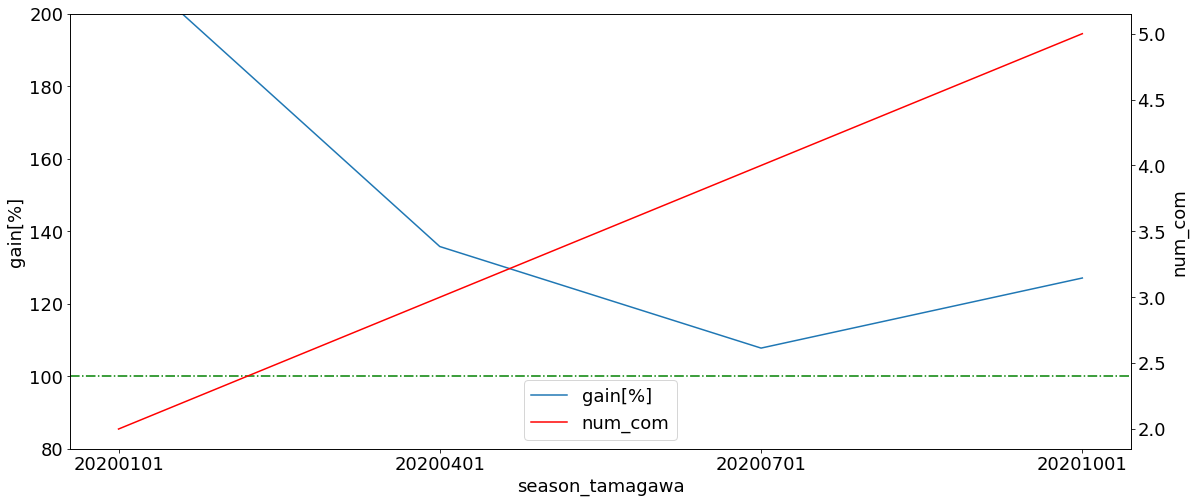

 50%|█████████████████████████████████████████▌                                         | 5/10 [00:00<00:00,  6.56it/s]

place_name: hamanako ========================================================================================


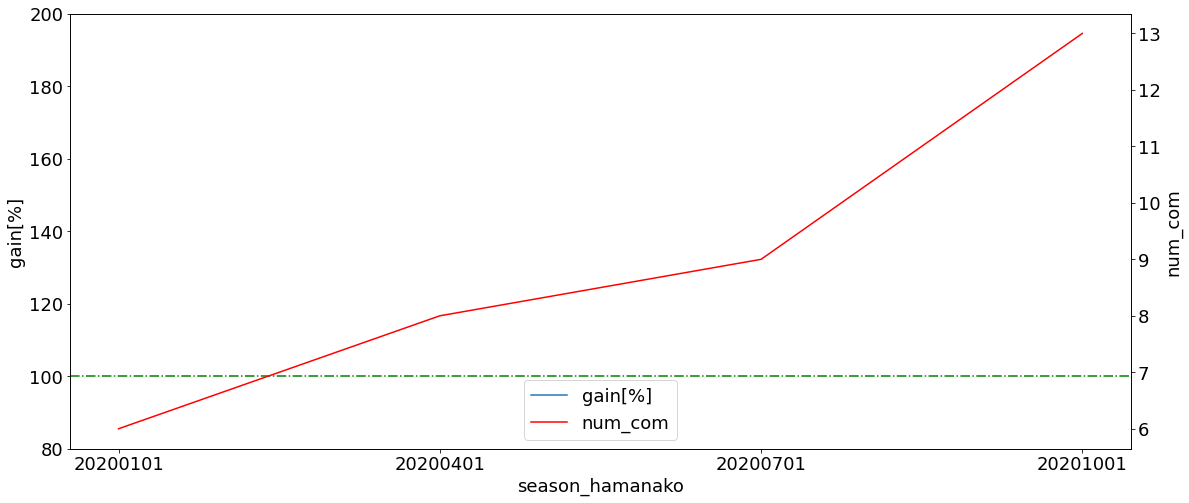

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:00<00:00,  6.66it/s]

place_name: gamagori ========================================================================================


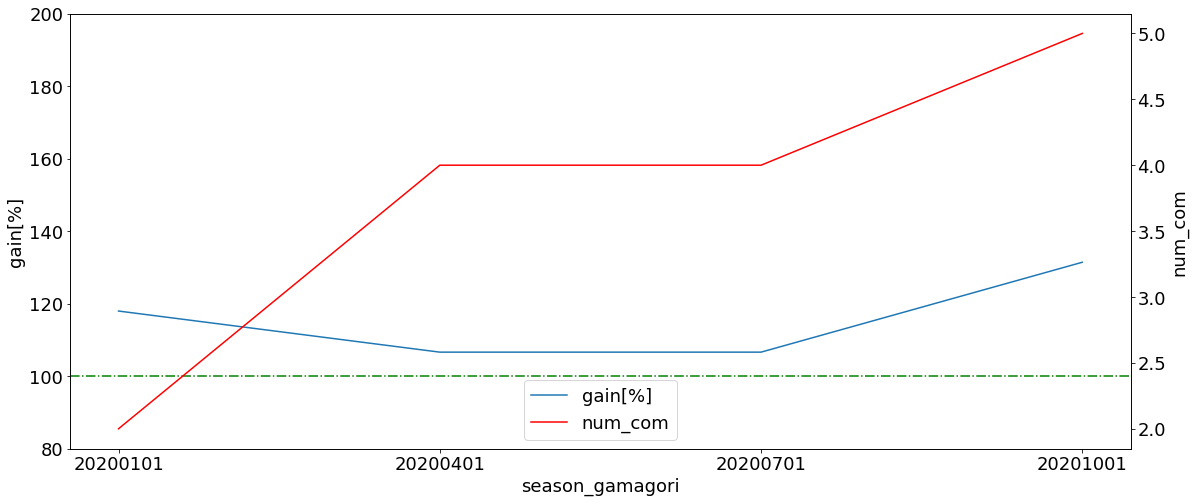

 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:01<00:00,  6.70it/s]

place_name: tokoname ========================================================================================


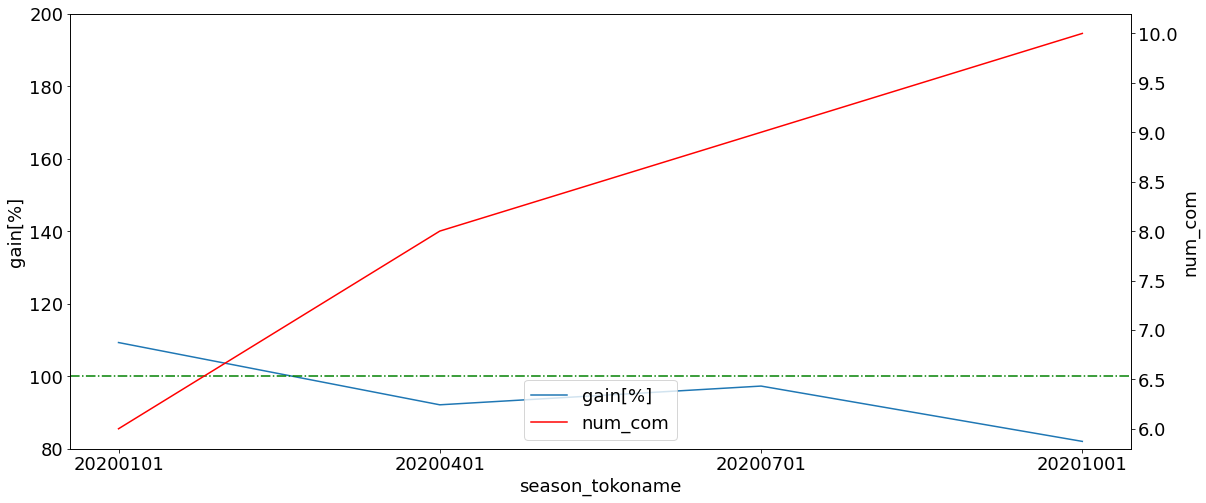

 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:01<00:00,  6.66it/s]

place_name: tu ========================================================================================


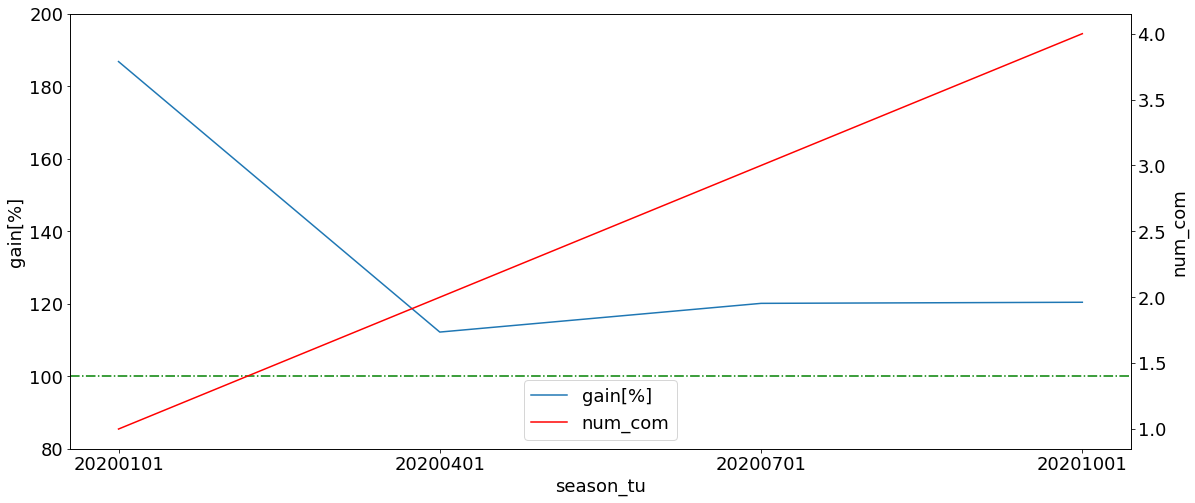

 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:01<00:00,  6.55it/s]

place_name: mikuni ========================================================================================


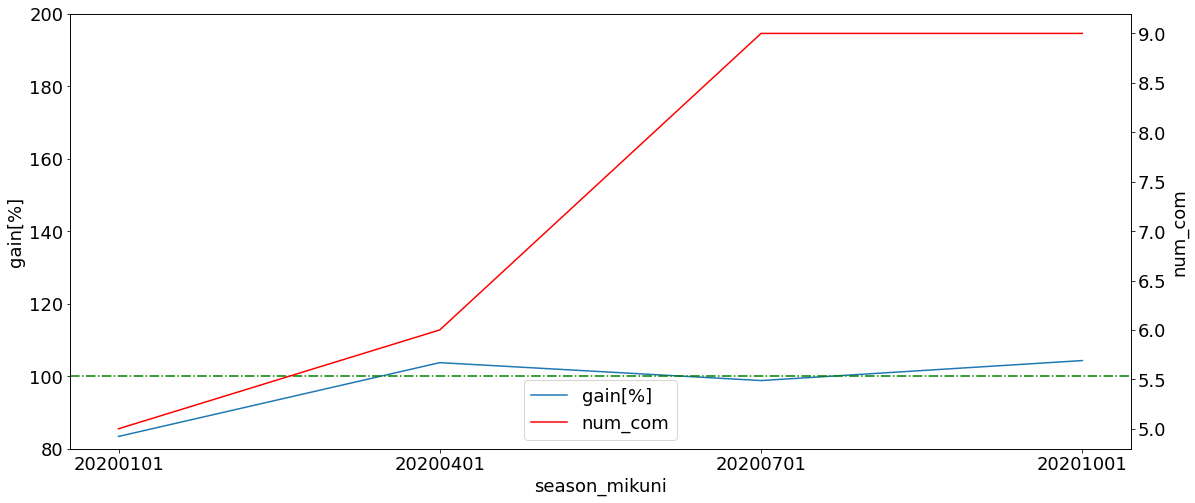

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.39it/s]


In [37]:

version='V4_2'
for place_name in tqdm(place_names[:10]):
    print('place_name:',place_name,'========================================================================================')
    gain_arr=[0]*4
    n_com_arr=[0]*4
    date_arr=[0]*4
    for i in range(4):
        now_ym=datetime.datetime(year=2020, month=1+(i*3),day=1).strftime('%Y%m%d')
        dir_path = "../../bot_database/{place_name}/model_score_{place_name}/use_model/{version}/use_model_{place_name}_{now_ym}_{version}.csv".format(place_name=place_name,version=version,now_ym=now_ym)#作成したデータの書き込み先#使用するデータの読み込み
        use_models=pd.read_csv(dir_path, encoding='utf_8_sig')
        s_t_use=use_models['total_use_final'].sum()
        s_t_get=use_models['total_get_final'].sum()
        s_gain=(s_t_get/s_t_use)*100
        gain_arr[i]=s_gain
        n_com_arr[i]=len(use_models)
        date_arr[i]=now_ym
    x_n='season_{place_name}'.format(place_name=place_name)
    y1_n='gain[%]'
    y2_n='num_com'
    twin_plt(date_arr,gain_arr,n_com_arr,x_n,y1_n,y2_n)

In [38]:
th_s

minus_model_per_mean               40.159193
num_plus_com_mean                   2.250000
num_plus_model_mean                20.000000
gain_th                            96.000000
gain_std_th                        70.000000
hit_per_th                          2.000000
hit_std_th                          0.800000
num_hit_th                         10.000000
st_20200101_minus_per(model)       53.571429
st_20200101_num_plus_com            1.000000
st_20200101_num_plus_model(row)    13.000000
st_20200401_minus_per(model)        0.000000
st_20200401_num_plus_com            1.000000
st_20200401_num_plus_model(row)     2.000000
st_20200701_minus_per(model)       90.163934
st_20200701_num_plus_com            3.000000
st_20200701_num_plus_model(row)     6.000000
st_20201001_minus_per(model)       16.901408
st_20201001_num_plus_com            4.000000
st_20201001_num_plus_model(row)    59.000000
Name: 63407, dtype: float64

## 日付を与えると区間の開始日を返してくれる関数を作る

In [43]:
def get_season_date(now_date):#日付(datetime型)を渡すと，その日付で購買予測を行う際に使用するデータの区間を返す関数
    use_data_year=now_date.year
    if (now_date.month>=1)and(now_date.month<4):
        use_data_month=1
    elif (now_date.month>=4)and(now_date.month<7):
        use_data_month=4
    elif (now_date.month>=7)and(now_date.month<10):
        use_data_month=7
    elif (now_date.month>=10):
        use_data_month=10
    else:
        print('what???????')
    use_data_date=datetime.datetime(year=use_data_year, month=use_data_month,day=1)
    return use_data_date

In [48]:
today=datetime.date.today()
for i in range(4):
    #now_ym=datetime.datetime(year=2020, month=1+(i*3),day=1).strftime('%Y%m%d')
    now_ym=datetime.datetime(year=2020, month=1+(i*3),day=1)
    data_ym=get_season_date(now_ym)
    html_ym=data_ym- datetime.timedelta(days=1)
    print('now_ym',now_ym)
    print('data_ym',data_ym)
    print('html_ym',html_ym)
    print('===========================================================')

now_ym 2020-01-01 00:00:00
data_ym 2020-01-01 00:00:00
html_ym 2019-12-31 00:00:00
now_ym 2020-04-01 00:00:00
data_ym 2020-04-01 00:00:00
html_ym 2020-03-31 00:00:00
now_ym 2020-07-01 00:00:00
data_ym 2020-07-01 00:00:00
html_ym 2020-06-30 00:00:00
now_ym 2020-10-01 00:00:00
data_ym 2020-10-01 00:00:00
html_ym 2020-09-30 00:00:00


In [49]:
now_ym=datetime.date.today()
data_ym=get_season_date(now_ym)
html_ym=data_ym- datetime.timedelta(days=1)
print('now_ym',now_ym)
print('data_ym',data_ym)
print('html_ym',html_ym)
print('===========================================================')

now_ym 2021-10-16
data_ym 2021-10-01 00:00:00
html_ym 2021-09-30 00:00:00


In [40]:
print(today)
print(type(today))

2021-10-16
<class 'datetime.date'>


In [6]:
# # 芦屋だけでひとまず機能を完成させる
# #きめのパラメータ
# place_name='asiya'
# plus_m_th=3
# num_hit_th=5
# version='V4_2'
# mode='asiya_model_score_'
# mode_type='recent'
# csv_path='../../bot_database/{place_name}/model_score_{place_name}/v4_score/{version}/{version}_{mode_type}_TRhit_pM{plus_month}_total_analysis.csv'.format(place_name=place_name,mode_type=mode_type,version=version,plus_month=plus_m_th,num_hit=num_hit_th)
# totol_analysis_df=pd.read_csv(csv_path, encoding='utf_8_sig')
# totol_analysis_df=totol_analysis_df.drop(["Unnamed: 0"],axis=1)

# #閾値の取得
# #th_s=totol_analysis_df[totol_analysis_df['num_plus_com_mean']>3].sort_values('minus_model_per_mean').iloc[0]
# th_s=totol_analysis_df[(totol_analysis_df['num_plus_com_mean']>3) & (totol_analysis_df['num_hit_th']>=10)].sort_values('minus_model_per_mean').iloc[0]
# select_model_df=pd.DataFrame()
# #閾値にあてはまった　モデルたちがどんな奴らなのかを確認する
# for i in range(4):
#     now_ym=datetime.datetime(year=2020, month=1+(i*3),day=1).strftime('%Y%m%d')
#     dir_path='../../bot_database/{place_name}/model_score_{place_name}/v4_score/{version}/{mode}st{now_ym}_finalM3_{version}.csv'.format(place_name=place_name,mode=mode,now_ym=now_ym,version=version)
#     model_score_df=pd.read_csv(dir_path, encoding='utf_8_sig')
#     model_score_df=model_score_df.drop(["Unnamed: 0"],axis=1)
#     #選定したパラメータで切り落とし

    
#     selected_m=model_score_df[model_score_df['gain_test']>=th_s["gain_th"]].copy()
#     selected_m=selected_m[selected_m['gain_std_test']<=th_s["gain_std_th"]].copy()
#     selected_m=selected_m[selected_m['buy_hit_per_test']>=th_s["hit_per_th"]].copy()
#     selected_m=selected_m[selected_m['buy_hit_per_std_test']<=th_s["hit_std_th"]].copy()
#     selected_m=selected_m[selected_m['num_hit_test']>=th_s["num_hit_th"]].copy()#的中した予測の数で切り捨てる,これも可変していく方針に変更した
#     print(now_ym,'=============================================')
#     display(selected_m)
#     select_model_df=pd.concat([select_model_df, selected_m], axis=0)#きめのパラメータで切り落としたので結合
#     #偏差値評価を用いた実際に使用するモデルの切り抜き
#     model_score_df=add_std_score(selected_m)
#     use_models=select_use_model(model_score_df)
#     use_models.to_csv('csv/use_model_df_{}.csv'.format(now_ym))

# #select_model_df.to_csv('check_model2.csv', encoding='utf_8_sig')
# #相関係数の算出（範囲は-1～1）
# #version_corr_df=version_df.corr()

## 偏差値評価の機能を作る
=今までの偏差値評価部分との変更点
評価に相関係数を用いることで，finalのgainに関係のあるもの程重みを上げて，総合的な評価を自動的に行えるようにする

### 相関係数と偏差値を使ったモデル選定

In [ ]:
target_com_df.to_csv('model_select.csv')

In [ ]:
feature_weights.index

In [ ]:
select_model_df

In [ ]:
model_score_df